In [1]:
import re
import math
import pandas as pd
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [2]:
games = pd.read_csv("./data/games.csv")
players = pd.read_csv("./data/players.csv")
plays = pd.read_csv("./data/plays_with_target.csv").drop(['Unnamed: 0'], axis=1)
weeks = [] 
for i in range(1,18):
    weeks.append(pd.read_csv("./data/week{}_with_both.csv".format(i)).drop(['Unnamed: 0'], axis=1))

In [3]:
def posession(plays_row):
    if games.query("gameId=={}".format(plays_row.gameId)).visitorTeamAbbr.iloc[0] == plays_row.possessionTeam:
        return 'away'
    else:
        return 'home'
    
def get_week(gameID, playID):
    return games.query("gameId=={}".format(gameID)).iloc[0].week - 1
    
def get_week_df(gameID, playID):
    wk = get_week(gameID, playID)
    week_df = weeks[wk]
    information = week_df[(week_df.playId==playID)&(week_df.gameId==gameID)]
    return information, wk

# this function requires 'plays' dataframe
def animate_play(gameID, playID):
    plt.close('all')
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(14)
    
    information, wk = get_week_df(gameID, playID)
    max_frame = information.frameId.max()
    print("GAME: {}\tPLAY: {}\tWEEK: {}\tFRAME: {}".format(gameID, playID, wk, max_frame))
    
    home, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C0')
    away, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C1')
    foot, = ax.plot([],[], linestyle='None', marker='o', markersize=12, c='C2')
    lines = [home, away, foot]
    
    def draw_field():
        ax.set_xlim(0, 120)
        ax.set_ylim(-5, 58.3)
        # Endzones
        ax.add_patch(Rectangle((  0, 0), width=10, height=53.3, alpha=0.5, color='grey'))
        ax.add_patch(Rectangle((110, 0), width=10, height=53.3, alpha=0.5, color='grey'))
        # Sidelines
        ax.plot([0,120],[0,0], c='grey', linewidth=2)
        ax.plot([0,120],[53.3,53.3], c='grey', linewidth=2)
        for i in range(10, 120, 10):
            # 10 Yard lines
            ax.plot([i,i],[0,53.3], c='grey', linewidth=2)
            if abs(60-i) <=40:
                # Numbers
                ax.text(i-2.5, 12, str(50-abs(60-i)), color="grey", fontsize=24)
                ax.text(i-2.5, 41.3, str(50-abs(60-i)), color="grey", fontsize=24, rotation=180)
        # Hash marks
        for i in range(10, 110):
            ax.plot([i,i], [0, 1], c='grey')
            ax.plot([i,i], [23, 24], c='grey')
            ax.plot([i,i], [29.3, 30.3], c='grey')
            ax.plot([i,i], [52.3, 53.3], c='grey')
        
        # Drawing the line of scrimmage
        scrimmage = information.query("frameId==1 and displayName=='Football'").iloc[0].x
        ax.plot([scrimmage,scrimmage],[0, 53.3], c='darkblue', linewidth=2)
        
        # Drawing the First Down Line
        play_information = plays.query("playId=={} and gameId=={}".format(playID, gameID)).iloc[0]
        ax.set_title(play_information.playDescription)
        home_team = games[games.gameId==gameID].iloc[0].homeTeamAbbr
        poss_team = play_information.possessionTeam
        team_query_term = "home"
        if home_team != poss_team:
            team_query_term = "away"
        shit = information.query("frameId==1 and team=='{}'".format(team_query_term)).iloc[0].x
        first_down_line = scrimmage - play_information.yardsToGo
        if shit < scrimmage:
            first_down_line = scrimmage + play_information.yardsToGo
        ax.plot([first_down_line,first_down_line],[0, 53.3], c='gold', linewidth=2)
        return lines

    def plot_players(t):
        home_filtered = information[(information.frameId==t)&(information.team=="home")]
        away_filtered = information[(information.frameId==t)&(information.team=="away")]
        foot_filtered = information[(information.frameId==t)&(information.team=="football")]
        home.set_data(home_filtered.x.array, home_filtered.y.array)
        away.set_data(away_filtered.x.array, away_filtered.y.array)
        foot.set_data(foot_filtered.x.array, foot_filtered.y.array)
        lines = [home, away, foot]
        
        if t%10 == 0:
            print(t,end = ',')
        return lines
    
    return animation.FuncAnimation(fig, plot_players, frames=range(1, max_frame+1), init_func=draw_field, blit=True)
    #return animation.FuncAnimation(fig, plot_players, frames=range(20, 21), init_func=draw_field, blit=True)

# Find 'Cover'
There are 2 methods:
1. Parse playDescription and find cover. Usually in parenthesis?
2. Find the closest players to the football
3. Find the closest players to the target

Method 1 turns out to be quite challenging. Some names are in parenthesis and some are in brackets. Some don't have them at all. No defense mentioned. 

Method 2 turns out to be good but not good enough. When the defense is playing zone, there are multiple DBs that are guarding the target, but often it's hard to identify that. Also, when the pass is incomplete and wizzes by the target and the DB, the number of frames that the two players are close can be 1 frame. So this method is pretty sub-optimal as well.

This is why I had distance to the target calculated. Let's see how that performs

# Method 1: Parse the playDescription
Here is the testing process for regex-ing out the names that could be covers from playDescriptions

In [4]:
hell = "(?!No Huddle)(?!Shotgun)(?!sack)([a-zA-Z\.\s\-\',;])+"
for i in range(len(plays)):
    shit = plays.iloc[i] 
    shat = "(\["+hell+"\]|\("+hell+"\)|Coverage [0-9a-zA-Z\-\'\s]+(\.|\,)|INTERCEPTED by [A-Z]{1}\.[A-Z]{1}[-\'a-zA-Z]+\s)"
    shot = re.search(shat, shit.playDescription)
    if shot:
        fuck = re.sub("([\s\(\)\]\[\-0-9]|INTERCEPTED by|Coverage by|Coverage )" ,'',shot.group(0)).strip()
        fuck = re.split("[,;]", fuck)
        print(shit.passResult,"\t",shit.gameId,",",shit.playId, '\t',fuck)
    

C 	 2018090600 , 75 	 ['M.Jenkins']
I 	 2018090600 , 146 	 ['J.Mills', 'J.Hicks']
C 	 2018090600 , 190 	 ['R.Darby']
C 	 2018090600 , 320 	 ['R.Alford']
I 	 2018090600 , 344 	 ['R.Allen']
C 	 2018090600 , 492 	 ['R.McLeod']
C 	 2018090600 , 521 	 ['N.Gerry']
C 	 2018090600 , 752 	 ['R.Alford']
S 	 2018090600 , 776 	 ['B.Poole']
S 	 2018090600 , 839 	 ['Aborted']
I 	 2018090600 , 889 	 ['R.Darby']
C 	 2018090600 , 949 	 ['B.Graham']
C 	 2018090600 , 992 	 ['D.Campbell']
C 	 2018090600 , 1037 	 ['R.Alford']
C 	 2018090600 , 1061 	 ['R.Alford']
C 	 2018090600 , 1085 	 ['B.Poole']
C 	 2018090600 , 1202 	 ['D.Jones']
I 	 2018090600 , 1295 	 ['D.Riley']
C 	 2018090600 , 1344 	 ['D.Jones', 'D.Campbell']
C 	 2018090600 , 1423 	 ['R.Darby']
C 	 2018090600 , 1473 	 ['R.McLeod']
S 	 2018090600 , 1568 	 ['J.Hicks']
C 	 2018090600 , 1680 	 ['D.Jones']
C 	 2018090600 , 1750 	 ['D.Trufant']
C 	 2018090600 , 1869 	 ['J.Mills']
I 	 2018090600 , 1894 	 ['R.McLeod']
C 	 2018090600 , 1916 	 ['M.Jenkins']


C 	 2018090905 , 2433 	 ['K.Jackson']
C 	 2018090905 , 2471 	 ['D.Harmon']
C 	 2018090905 , 2516 	 ['S.Gilmore']
I 	 2018090905 , 2600 	 ['A.Clayborn']
C 	 2018090905 , 2686 	 ['Z.Cunningham']
C 	 2018090905 , 2710 	 ['J.Joseph']
C 	 2018090905 , 2777 	 ['D.Cole']
I 	 2018090905 , 2839 	 ['D.Cole']
I 	 2018090905 , 2861 	 ['J.Watt']
C 	 2018090905 , 2949 	 ['D.McCourty', 'A.Butler']
C 	 2018090905 , 3078 	 ['E.Rowe']
C 	 2018090905 , 3125 	 ['D.Harmon', 'S.Gilmore']
C 	 2018090905 , 3218 	 ['D.Cole']
C 	 2018090905 , 3242 	 ['K.Johnson', 'W.Mercilus']
I 	 2018090905 , 3283 	 ['J.Watt']
C 	 2018090905 , 3305 	 ['W.Mercilus', 'K.Johnson']
C 	 2018090905 , 3371 	 ['T.Mathieu', 'B.McKinney']
C 	 2018090905 , 3395 	 ['T.Mathieu']
S 	 2018090905 , 3445 	 ['D.Reader']
C 	 2018090905 , 3546 	 ['S.Gilmore']
S 	 2018090905 , 3591 	 ['T.Flowers']
C 	 2018090905 , 3645 	 ['D.McCourty']
S 	 2018090905 , 3709 	 ['D.Reader']
I 	 2018090905 , 3822 	 ['J.Jones']
C 	 2018090905 , 4142 	 ['J.Joseph']
I 	

C 	 2018090912 , 983 	 ['K.Brice']
C 	 2018090912 , 1103 	 ['E.Jackson']
S 	 2018090912 , 1127 	 ['R.RobertsonHarris']
I 	 2018090912 , 1216 	 ['J.Whitehead']
C 	 2018090912 , 1259 	 ['B.Martinez']
S 	 2018090912 , 1300 	 ['N.Perry']
C 	 2018090912 , 1371 	 ['A.Amos']
C 	 2018090912 , 1395 	 ['D.Trevathan']
C 	 2018090912 , 1419 	 ['P.Amukamara']
S 	 2018090912 , 1464 	 ['K.Mack']
C 	 2018090912 , 1493 	 ['K.King']
C 	 2018090912 , 1639 	 ['B.Callahan']
S 	 2018090912 , 1666 	 ['R.Smith']
IN 	 2018090912 , 1724 	 ['K.Mack']
C 	 2018090912 , 1837 	 ['H.ClintonDix']
C 	 2018090912 , 1882 	 ['J.Alexander']
C 	 2018090912 , 1939 	 ['R.Gilbert', 'T.Williams']
C 	 2018090912 , 1985 	 ['K.Brice']
C 	 2018090912 , 2030 	 ['H.ClintonDix']
C 	 2018090912 , 2080 	 ['B.Martinez']
C 	 2018090912 , 2205 	 ['N.Kwiatkoski']
C 	 2018090912 , 2258 	 ['B.Callahan']
C 	 2018090912 , 2282 	 ['N.Kwiatkoski']
C 	 2018090912 , 2348 	 ['B.Callahan']
C 	 2018090912 , 2372 	 ['B.Callahan']
C 	 2018090912 , 2495 

S 	 2018091602 , 2117 	 ['D.Hunter']
C 	 2018091602 , 2136 	 ['T.Waynes']
C 	 2018091602 , 2160 	 ['X.Rhodes']
C 	 2018091602 , 2212 	 ['X.Rhodes']
I 	 2018091602 , 2236 	 ['S.Weatherly']
I 	 2018091602 , 2289 	 ['S.Richardson']
C 	 2018091602 , 2366 	 ['B.Martinez']
I 	 2018091602 , 2390 	 ['R.Gilbert']
S 	 2018091602 , 2459 	 ['D.Parry']
C 	 2018091602 , 2478 	 ['T.Waynes']
C 	 2018091602 , 2547 	 ['J.Whitehead']
C 	 2018091602 , 2595 	 ['J.Alexander']
I 	 2018091602 , 2619 	 ['R.Gilbert']
C 	 2018091602 , 2641 	 ['J.Alexander']
C 	 2018091602 , 2665 	 ['H.ClintonDix']
C 	 2018091602 , 2799 	 ['M.Hughes']
C 	 2018091602 , 2860 	 ['A.Sendejo', 'E.Kendricks']
C 	 2018091602 , 2884 	 ['E.Kendricks']
C 	 2018091602 , 3004 	 ['H.Smith']
I 	 2018091602 , 3100 	 ['K.Clark']
C 	 2018091602 , 3180 	 ['A.Sendejo']
C 	 2018091602 , 3236 	 ['T.Waynes']
C 	 2018091602 , 3293 	 ['M.Alexander']
C 	 2018091602 , 3378 	 ['A.Sendejo']
I 	 2018091602 , 3461 	 ['E.Griffen']
IN 	 2018091602 , 3517 	 ['H.

I 	 2018091605 , 119 	 ['Murray.']
C 	 2018091605 , 309 	 ['K.Fuller']
I 	 2018091605 , 338 	 ['Aborted']
C 	 2018091605 , 447 	 ['J.Bostic']
C 	 2018091605 , 471 	 ['S.Davis']
C 	 2018091605 , 621 	 ['E.Murray']
I 	 2018091605 , 645 	 ['D.Ford']
C 	 2018091605 , 746 	 ['E.Murray']
C 	 2018091605 , 799 	 ['Te.Smith']
I 	 2018091605 , 823 	 ['Scandrick.']
I 	 2018091605 , 849 	 ['Scandrick.']
C 	 2018091605 , 895 	 ['A.Burns']
I 	 2018091605 , 984 	 ['T.Watt']
C 	 2018091605 , 1097 	 ['R.Parker']
C 	 2018091605 , 1180 	 ['R.Ragland']
C 	 2018091605 , 1209 	 ['E.Murray']
C 	 2018091605 , 1273 	 ['K.Fuller']
C 	 2018091605 , 1348 	 ['S.Tuitt', 'A.Chickillo']
S 	 2018091605 , 1372 	 ['D.McCullers']
C 	 2018091605 , 1470 	 ['K.Fuller']
C 	 2018091605 , 1499 	 ['Tr.Smith']
C 	 2018091605 , 1549 	 ['J.Houston']
C 	 2018091605 , 1573 	 ['X.Williams']
I 	 2018091605 , 1597 	 ['Scandrick.']
C 	 2018091605 , 1619 	 ['R.Ragland']
C 	 2018091605 , 1647 	 ['Te.Smith']
I 	 2018091605 , 1671 	 ['Nelso

S 	 2018091610 , 433 	 ['D.Kennard']
C 	 2018091610 , 516 	 ['K.Williams']
C 	 2018091610 , 566 	 ['R.Sherman']
C 	 2018091610 , 636 	 ['K.Williams']
C 	 2018091610 , 773 	 ['T.Wilson']
C 	 2018091610 , 823 	 ['T.Tabor']
C 	 2018091610 , 872 	 ['J.Davis', 'T.Tabor']
C 	 2018091610 , 961 	 ['G.Quin']
C 	 2018091610 , 1071 	 ['Q.Diggs']
C 	 2018091610 , 1105 	 ['Q.Diggs']
C 	 2018091610 , 1256 	 ['E.Lee']
C 	 2018091610 , 1342 	 ['C.Jones', 'T.Wilson']
C 	 2018091610 , 1391 	 ['D.Slay']
C 	 2018091610 , 1465 	 ['S.Thomas']
S 	 2018091610 , 1514 	 ['E.Lee']
I 	 2018091610 , 1543 	 ['C.Jones']
S 	 2018091610 , 1591 	 ['E.Harold']
C 	 2018091610 , 1690 	 ['A.Witherspoon']
C 	 2018091610 , 1718 	 ['A.Armstead', 'K.Williams']
C 	 2018091610 , 1750 	 ['K.Williams']
I 	 2018091610 , 1886 	 ['Q.Diggs']
S 	 2018091610 , 1908 	 ['C.Jones']
I 	 2018091610 , 1996 	 ['D.Buckner']
C 	 2018091610 , 2040 	 ['A.Colbert', 'A.Witherspoon']
C 	 2018091610 , 2085 	 ['F.Warner']
C 	 2018091610 , 2157 	 ['E.Le

C 	 2018091613 , 3480 	 ['B.Jones']
C 	 2018091613 , 3509 	 ['L.VanderEsch']
C 	 2018091613 , 3533 	 ['L.VanderEsch']
I 	 2018091613 , 3574 	 ['J.Heath']
C 	 2018091613 , 3620 	 ['C.Awuzie']
C 	 2018091613 , 3649 	 ['J.Smith']
C 	 2018091700 , 139 	 ['K.Fuller']
C 	 2018091700 , 163 	 ['A.Amos']
S 	 2018091700 , 208 	 ['A.Lynch']
C 	 2018091700 , 353 	 ['A.Calitro']
C 	 2018091700 , 381 	 ['E.Thomas']
C 	 2018091700 , 426 	 ['B.McDougald']
C 	 2018091700 , 471 	 ['SL.Griffin']
C 	 2018091700 , 482 	 ['B.McDougald']
C 	 2018091700 , 646 	 ['P.Amukamara']
I 	 2018091700 , 691 	 ['P.Amukamara']
C 	 2018091700 , 799 	 ['A.Calitro']
S 	 2018091700 , 1043 	 ['E.Goldman']
C 	 2018091700 , 1072 	 ['P.Amukamara']
IN 	 2018091700 , 1147 	 ['A.RobinsonII']
I 	 2018091700 , 1194 	 ['L.Floyd']
C 	 2018091700 , 1319 	 ['A.King']
I 	 2018091700 , 1343 	 ['M.Kendricks']
C 	 2018091700 , 1365 	 ['SL.Griffin']
IN 	 2018091700 , 1389 	 ['B.McDougald']
S 	 2018091700 , 1415 	 ['E.Jackson']
S 	 2018091700 

I 	 2018092304 , 2362 	 ['B.Orakpo']
I 	 2018092304 , 2384 	 ['D.Morgan']
C 	 2018092304 , 2406 	 ['K.Byard']
C 	 2018092304 , 2430 	 ['J.Brown']
C 	 2018092304 , 2454 	 ['W.Woodyard']
I 	 2018092304 , 2478 	 ['W.Woodyard']
C 	 2018092304 , 2567 	 ['A.Bouye']
C 	 2018092304 , 2654 	 ['T.Herndon']
C 	 2018092304 , 2758 	 ['L.Sims', 'L.Ryan']
C 	 2018092304 , 2849 	 ['M.Butler']
C 	 2018092304 , 2895 	 ['H.Landry']
S 	 2018092304 , 2961 	 ['K.Vaccaro']
C 	 2018092304 , 2984 	 ['J.Brown']
C 	 2018092304 , 3083 	 ['W.Woodyard', 'J.Brown']
C 	 2018092304 , 3107 	 ['J.Brown']
C 	 2018092304 , 3207 	 ['T.Gipson']
C 	 2018092304 , 3273 	 ['B.Church']
C 	 2018092304 , 3330 	 ['Tel.Smith']
S 	 2018092304 , 3492 	 ['J.Casey']
C 	 2018092304 , 3567 	 ['J.Ramsey']
C 	 2018092304 , 3803 	 ['D.Cruikshank']
S 	 2018092301 , 79 	 ['B.Chubb']
C 	 2018092301 , 239 	 ['J.Simmons']
C 	 2018092301 , 296 	 ['S.Barrett']
C 	 2018092301 , 453 	 ['E.Weddle']
I 	 2018092301 , 477 	 ['Z.Smith']
C 	 2018092301 , 5

C 	 2018092308 , 341 	 ['A.Woods']
C 	 2018092308 , 365 	 ['C.Geathers']
C 	 2018092308 , 523 	 ['J.Mills']
I 	 2018092308 , 547 	 ['M.Bennett']
C 	 2018092308 , 605 	 ['C.Geathers']
C 	 2018092308 , 673 	 ['C.Geathers']
I 	 2018092308 , 729 	 ['D.Leonard']
S 	 2018092308 , 751 	 ['K.Turay']
C 	 2018092308 , 806 	 ['R.Darby']
I 	 2018092308 , 863 	 ['J.Hicks']
C 	 2018092308 , 885 	 ['F.Cox', 'C.Graham']
C 	 2018092308 , 909 	 ['S.Jones']
C 	 2018092308 , 1127 	 ['P.Desir', 'D.Leonard']
I 	 2018092308 , 1213 	 ['J.Mills']
I 	 2018092308 , 1303 	 ['C.Graham']
C 	 2018092308 , 1348 	 ['C.Geathers']
C 	 2018092308 , 1475 	 ['A.Walker']
C 	 2018092308 , 1548 	 ['N.Hairston']
C 	 2018092308 , 1572 	 ['M.Hooker']
I 	 2018092308 , 1643 	 ['N.Hairston']
C 	 2018092308 , 1700 	 ['J.Hicks']
C 	 2018092308 , 1724 	 ['J.Hicks']
C 	 2018092308 , 1748 	 ['J.Mills']
C 	 2018092308 , 1893 	 ['A.Walker']
C 	 2018092308 , 2002 	 ['C.Geathers']
I 	 2018092308 , 2107 	 ['J.Sheard']
C 	 2018092308 , 2148 	

C 	 2018092311 , 1775 	 ['R.Smith']
S 	 2018092311 , 1816 	 ['A.Hicks']
C 	 2018092311 , 1872 	 ['B.Baker']
IN 	 2018092311 , 1896 	 ['T.Boston']
S 	 2018092311 , 1989 	 ['K.Mack']
C 	 2018092311 , 2116 	 ['B.Baker', 'J.Bynes']
S 	 2018092311 , 2140 	 ['C.Jones']
C 	 2018092311 , 2201 	 ['D.Trevathan', 'P.Amukamara']
C 	 2018092311 , 2246 	 ['P.Amukamara']
IN 	 2018092311 , 2270 	 ['E.Jackson']
C 	 2018092311 , 2345 	 ['T.Boston']
C 	 2018092311 , 2390 	 ['B.Baker']
C 	 2018092311 , 2414 	 ['A.Bethea']
C 	 2018092311 , 2455 	 ['G.Hodges']
I 	 2018092311 , 2479 	 ['T.Boston']
C 	 2018092311 , 2627 	 ['E.Jackson']
I 	 2018092311 , 2674 	 ['K.Fuller']
IN 	 2018092311 , 2696 	 ['S.McManis']
C 	 2018092311 , 2815 	 ['J.Bynes']
C 	 2018092311 , 2912 	 ['T.Boston', 'J.Bynes']
C 	 2018092311 , 3029 	 ['A.Amos']
C 	 2018092311 , 3074 	 ['K.ToliverII']
C 	 2018092311 , 3098 	 ['E.Jackson']
S 	 2018092311 , 3149 	 ['K.Mack']
I 	 2018092311 , 3198 	 ['B.Benwikere']
C 	 2018092311 , 3220 	 ['B.Benw

C 	 2018092700 , 3606 	 ['A.Sendejo', 'H.Hill']
C 	 2018092700 , 3630 	 ['M.Hughes']
I 	 2018092700 , 3691 	 ['J.Kearse']
C 	 2018092700 , 3733 	 ['M.Peters']
C 	 2018092700 , 3786 	 ['C.Littleton', 'M.Christian']
C 	 2018092700 , 3810 	 ['C.Littleton', 'J.Johnson']
I 	 2018092700 , 3884 	 ['M.Christian']
S 	 2018092700 , 3906 	 ['N.Suh']
I 	 2018092700 , 3990 	 ['S.Richardson']
C 	 2018092700 , 4012 	 ['L.Joseph', 'S.Richardson']
S 	 2018092700 , 4089 	 ['A.Donald']
C 	 2018092700 , 4136 	 ['N.Robey']
C 	 2018092700 , 4170 	 ['J.Johnson']
S 	 2018092700 , 4194 	 ['J.Franklin']
C 	 2018093002 , 263 	 ['X.Woods', 'C.Awuzie']
C 	 2018093002 , 287 	 ['D.Wilson', 'J.Smith']
C 	 2018093002 , 332 	 ['D.Wilson']
C 	 2018093002 , 447 	 ['G.Quin']
C 	 2018093002 , 492 	 ['N.Lawson']
I 	 2018093002 , 537 	 ['D.Slay']
C 	 2018093002 , 622 	 ['J.Heath']
C 	 2018093002 , 651 	 ['X.Woods']
C 	 2018093002 , 681 	 ['J.Thomas']
I 	 2018093002 , 731 	 ['C.Awuzie']
C 	 2018093002 , 755 	 ['A.Brown']
I 	 

I 	 2018093000 , 726 	 ['D.Senat']
C 	 2018093000 , 818 	 ['R.Alford', 'D.Riley']
C 	 2018093000 , 842 	 ['D.Kazee']
C 	 2018093000 , 871 	 ['D.Kazee']
C 	 2018093000 , 991 	 ['J.Evans']
C 	 2018093000 , 1058 	 ['D.Dennard']
C 	 2018093000 , 1082 	 ['H.Nickerson', 'W.Jackson']
C 	 2018093000 , 1247 	 ['I.Oliver']
C 	 2018093000 , 1297 	 ['F.Oluokun']
I 	 2018093000 , 1447 	 ['D.Dennard']
C 	 2018093000 , 1507 	 ['W.Jackson']
C 	 2018093000 , 1531 	 ['J.Bates']
C 	 2018093000 , 1555 	 ['N.Vigil']
C 	 2018093000 , 1656 	 ['D.Trufant']
C 	 2018093000 , 1680 	 ['D.Senat']
C 	 2018093000 , 1760 	 ['F.Oluokun', 'D.Riley']
C 	 2018093000 , 1801 	 ['R.Alford']
C 	 2018093000 , 1825 	 ['D.Campbell']
C 	 2018093000 , 1924 	 ['N.Vigil']
C 	 2018093000 , 1976 	 ['J.Bates']
C 	 2018093000 , 2000 	 ['D.Dennard']
I 	 2018093000 , 2029 	 ['G.Atkins']
C 	 2018093000 , 2051 	 ['S.Williams']
C 	 2018093000 , 2080 	 ['H.Nickerson']
C 	 2018093000 , 2214 	 ['D.Campbell']
S 	 2018093000 , 2241 	 ['T.McKinle

I 	 2018093008 , 2187 	 ['B.Wagner']
C 	 2018093008 , 2331 	 ['T.Flowers']
C 	 2018093008 , 2418 	 ['A.Bethea']
C 	 2018093008 , 2489 	 ['B.Baker']
C 	 2018093008 , 2513 	 ['D.Bucannon']
I 	 2018093008 , 2807 	 ['B.McDougald']
C 	 2018093008 , 2882 	 ['T.Boston']
C 	 2018093008 , 3162 	 ['B.Mingo']
C 	 2018093008 , 3332 	 ['D.Bucannon']
C 	 2018093008 , 3482 	 ['B.McDougald']
C 	 2018093008 , 3542 	 ['B.Wagner']
I 	 2018093008 , 3706 	 ['C.Jones']
C 	 2018093008 , 3775 	 ['F.Clark']
C 	 2018093008 , 3799 	 ['B.Wagner']
C 	 2018093008 , 3844 	 ['B.Wagner', 'B.McDougald']
C 	 2018093008 , 3893 	 ['J.Coleman']
C 	 2018093008 , 4087 	 ['T.Boston']
C 	 2018093008 , 4132 	 ['T.Boston']
C 	 2018093009 , 76 	 ['T.Mitchell']
I 	 2018093009 , 177 	 ['M.Lee']
C 	 2018093009 , 246 	 ['T.Mitchell']
IN 	 2018093009 , 364 	 ['G.Conley']
C 	 2018093009 , 417 	 ['R.Melvin']
C 	 2018093009 , 477 	 ['R.Nelson']
I 	 2018093009 , 549 	 ['M.Hurst']
C 	 2018093009 , 593 	 ['T.Whitehead']
S 	 2018093009 , 638

C 	 2018093012 , 3398 	 ['T.Watt']
S 	 2018093012 , 3422 	 ['J.Hargrave']
C 	 2018093012 , 3441 	 ['C.Sensabaugh']
C 	 2018093012 , 3499 	 ['C.Mosley']
I 	 2018093012 , 3523 	 ['Judon.']
C 	 2018093012 , 3549 	 ['C.Mosley']
I 	 2018093012 , 3573 	 ['A.LevineSr.']
C 	 2018093012 , 3657 	 ['J.Bostic']
C 	 2018093012 , 3821 	 ['J.Haden', 'J.Bostic']
C 	 2018093012 , 3716 	 ['T.Watt', 'J.Haden']
C 	 2018093012 , 3740 	 ['J.Haden', 'S.Davis']
C 	 2018093012 , 3854 	 ['J.Haden']
I 	 2018093012 , 3900 	 ['Davis.']
I 	 2018093012 , 3926 	 ['Davis.']
I 	 2018093012 , 3997 	 ['C.Mosley']
I 	 2018093012 , 4019 	 ['Carr.']
IN 	 2018093012 , 4045 	 ['A.Levine']
C 	 2018093012 , 4248 	 ['A.LevineSr.']
S 	 2018093012 , 4272 	 ['T.Williams']
I 	 2018093012 , 4319 	 ['A.LevineSr.']
C 	 2018100100 , 51 	 ['R.Parker']
S 	 2018100100 , 145 	 ['D.Ford']
C 	 2018100100 , 164 	 ['K.Fuller']
C 	 2018100100 , 222 	 ['T.Davis']
C 	 2018100100 , 250 	 ['B.Roby']
C 	 2018100100 , 350 	 ['J.Simmons']
C 	 201810010

I 	 2018100707 , 660 	 ['Trufant.']
I 	 2018100707 , 761 	 ['Riley.']
I 	 2018100707 , 783 	 ['Alford.']
I 	 2018100707 , 867 	 ['D.Trufant']
S 	 2018100707 , 999 	 ['T.Watt']
C 	 2018100707 , 1018 	 ['J.Haden']
I 	 2018100707 , 1042 	 ['Burns.']
C 	 2018100707 , 1089 	 ['L.Fort', 'S.Davis']
I 	 2018100707 , 1164 	 ['D.Senat']
C 	 2018100707 , 1186 	 ['F.Oluokun', 'B.Carter']
I 	 2018100707 , 1214 	 ['V.Beasley']
C 	 2018100707 , 1265 	 ['J.Bostic']
I 	 2018100707 , 1310 	 ['Edmunds.']
C 	 2018100707 , 1417 	 ['J.Haden']
C 	 2018100707 , 1452 	 ['T.Matakevich']
C 	 2018100707 , 1497 	 ['C.Sensabaugh']
S 	 2018100707 , 1521 	 ['T.Watt']
I 	 2018100707 , 1540 	 ['Haden.']
S 	 2018100707 , 1566 	 ['C.Heyward']
I 	 2018100707 , 1758 	 ['M.Hilton']
C 	 2018100707 , 1780 	 ['L.Fort']
C 	 2018100707 , 1854 	 ['B.Poole']
C 	 2018100707 , 1878 	 ['R.Alford']
C 	 2018100707 , 1902 	 ['B.Poole']
I 	 2018100707 , 1987 	 ['D.Trufant']
IN 	 2018100707 , 2010 	 ['D.Kazee']
C 	 2018100707 , 2047 	 ['M

C 	 2018100703 , 377 	 ['J.Collins']
I 	 2018100703 , 401 	 ['D.Ward']
I 	 2018100703 , 423 	 ['E.Gaines']
C 	 2018100703 , 532 	 ['C.Mosley']
C 	 2018100703 , 556 	 ['T.Jefferson']
C 	 2018100703 , 622 	 ['M.Judon']
S 	 2018100703 , 689 	 ['E.Weddle']
C 	 2018100703 , 727 	 ['J.Schobert']
C 	 2018100703 , 751 	 ['D.Ward', 'C.Kirksey']
I 	 2018100703 , 796 	 ['J.Schobert']
I 	 2018100703 , 995 	 ['L.Ogunjobi']
C 	 2018100703 , 1017 	 ['D.Randall']
I 	 2018100703 , 1062 	 ['J.Peppers']
C 	 2018100703 , 1084 	 ['J.Peppers']
C 	 2018100703 , 1108 	 ['C.Kirksey']
IN 	 2018100703 , 1200 	 ['D.Ward']
C 	 2018100703 , 1226 	 ['C.Mosley']
I 	 2018100703 , 1250 	 ['A.LevineSr.']
I 	 2018100703 , 1304 	 ['P.Onwuasor']
C 	 2018100703 , 1326 	 ['T.Jefferson']
C 	 2018100703 , 1412 	 ['J.Peppers']
I 	 2018100703 , 1436 	 ['J.Schobert']
C 	 2018100703 , 1519 	 ['A.LevineSr.', 'E.Weddle']
C 	 2018100703 , 1602 	 ['E.Gaines']
C 	 2018100703 , 1701 	 ['B.Carr']
C 	 2018100703 , 1751 	 ['E.Weddle']
C 	 

C 	 2018100710 , 2964 	 ['P.Peterson']
I 	 2018100710 , 3253 	 ['G.Mabin']
C 	 2018100710 , 3275 	 ['C.Marsh', 'K.Williams']
C 	 2018100710 , 3322 	 ['T.Boston']
C 	 2018100710 , 3360 	 ['J.Bynes']
C 	 2018100710 , 3435 	 ['T.Boston', 'P.Peterson']
C 	 2018100710 , 3508 	 ['A.Bethea']
C 	 2018100710 , 3583 	 ['B.Benwikere']
I 	 2018100710 , 3659 	 ['H.Reddick']
I 	 2018100710 , 3742 	 ['E.Mitchell']
C 	 2018100710 , 3826 	 ['B.Benwikere', 'J.Bynes']
S 	 2018100710 , 3875 	 ['H.Reddick']
C 	 2018100710 , 3948 	 ['B.Benwikere']
S 	 2018100710 , 4002 	 ['B.Baker']
IN 	 2018100710 , 4057 	 ['B.Benwikere']
C 	 2018100710 , 4283 	 ['Z.Moore', 'B.Baker']
C 	 2018100710 , 4307 	 ['B.Baker']
I 	 2018100710 , 4335 	 ['T.Boston']
C 	 2018100710 , 4361 	 ['B.Baker']
C 	 2018100710 , 4390 	 ['B.Baker']
I 	 2018100710 , 4418 	 ['H.Reddick']
C 	 2018100710 , 4444 	 ['J.Bynes', 'B.Benwikere']
C 	 2018100710 , 4510 	 ['T.Boston']
C 	 2018100709 , 51 	 ['J.Hicks']
C 	 2018100709 , 75 	 ['J.Mills']
C 	 2

C 	 2018101100 , 3630 	 ['J.Mills', 'J.Hicks']
C 	 2018101100 , 3654 	 ['N.Bradham']
C 	 2018101100 , 3699 	 ['N.Bradham', 'A.Maddox']
S 	 2018101100 , 3723 	 ['F.Cox']
C 	 2018101100 , 3764 	 ['J.Mills', 'M.Jenkins']
I 	 2018101100 , 3791 	 ['N.Bradham']
C 	 2018101100 , 3813 	 ['T.Sullivan', 'M.Bennett']
I 	 2018101100 , 3837 	 ['F.Cox']
I 	 2018101100 , 3859 	 ['J.Mills']
C 	 2018101100 , 3940 	 ['L.Collins']
C 	 2018101100 , 4051 	 ['A.Ogletree']
C 	 2018101100 , 4222 	 ['N.Bradham']
C 	 2018101100 , 4246 	 ['J.Hicks']
C 	 2018101403 , 126 	 ['S.Wright']
C 	 2018101403 , 150 	 ['T.Mathieu']
C 	 2018101403 , 206 	 ['Z.Cunningham']
I 	 2018101403 , 303 	 ['T.Mathieu']
C 	 2018101403 , 425 	 ['T.Edmunds']
S 	 2018101403 , 477 	 ['K.Williams']
C 	 2018101403 , 502 	 ['L.Alexander']
C 	 2018101403 , 598 	 ['E.Yarbrough']
C 	 2018101403 , 643 	 ['M.Milano', 'P.Gaines']
S 	 2018101403 , 837 	 ['B.McKinney']
I 	 2018101403 , 886 	 ['P.Gaines']
C 	 2018101403 , 1049 	 ['M.Hyde']
I 	 2018101

C 	 2018101404 , 1881 	 ['R.McMillan']
IN 	 2018101404 , 2046 	 ['K.Fuller']
C 	 2018101404 , 2144 	 ['A.Amos']
C 	 2018101404 , 2189 	 ['K.Fuller']
I 	 2018101404 , 2256 	 ['B.Callahan']
C 	 2018101404 , 2312 	 ['T.McTyer']
C 	 2018101404 , 2439 	 ['A.Amos']
C 	 2018101404 , 2505 	 ['A.Amos']
C 	 2018101404 , 2615 	 ['K.Fuller']
C 	 2018101404 , 2639 	 ['A.Lynch']
C 	 2018101404 , 2762 	 ['R.Jones']
C 	 2018101404 , 2846 	 ['C.Tankersley']
IN 	 2018101404 , 2953 	 ['T.McDonald']
C 	 2018101404 , 3012 	 ['B.Callahan']
C 	 2018101404 , 3041 	 ['E.Jackson']
C 	 2018101404 , 3065 	 ['E.Jackson']
C 	 2018101404 , 3159 	 ['T.McDonald']
I 	 2018101404 , 3237 	 ['M.Fitzpatrick']
C 	 2018101404 , 3282 	 ['K.Alonso']
I 	 2018101404 , 3407 	 ['R.Jones']
C 	 2018101404 , 3568 	 ['K.Alonso']
C 	 2018101404 , 3592 	 ['X.Howard']
C 	 2018101404 , 3633 	 ['K.Alonso']
C 	 2018101404 , 3690 	 ['E.Jackson']
C 	 2018101404 , 3714 	 ['R.Smith']
C 	 2018101404 , 3905 	 ['A.Amos']
C 	 2018101404 , 4071 	 ['

C 	 2018101409 , 1266 	 ['L.Joyner']
C 	 2018101409 , 1425 	 ['L.Joyner']
C 	 2018101409 , 1505 	 ['B.Roby']
C 	 2018101409 , 1533 	 ['D.Stewart']
I 	 2018101409 , 1576 	 ['W.Parks']
C 	 2018101409 , 1598 	 ['J.Simmons']
C 	 2018101409 , 1689 	 ['J.Lawler']
C 	 2018101409 , 1737 	 ['C.Littleton']
C 	 2018101409 , 1778 	 ['J.Johnson']
C 	 2018101409 , 1811 	 ['E.Westbrooks']
C 	 2018101409 , 1878 	 ['M.Christian']
S 	 2018101409 , 1963 	 ['L.Joyner']
S 	 2018101409 , 1982 	 ['B.Chubb']
S 	 2018101409 , 2042 	 ['B.Chubb']
C 	 2018101409 , 2194 	 ['C.Harris']
C 	 2018101409 , 2364 	 ['T.Hill']
S 	 2018101409 , 2414 	 ['A.Donald']
C 	 2018101409 , 2538 	 ['C.Harris']
C 	 2018101409 , 2562 	 ['T.Brock', 'Z.Kerr']
C 	 2018101409 , 2754 	 ['T.Hill']
C 	 2018101409 , 2853 	 ['L.Joyner']
IN 	 2018101409 , 2898 	 ['J.Johnson']
I 	 2018101409 , 2924 	 ['B.Roby']
IN 	 2018101409 , 2967 	 ['D.Stewart']
C 	 2018101409 , 3252 	 ['D.Stewart']
S 	 2018101409 , 3343 	 ['B.Chubb']
C 	 2018101409 , 3382 	

I 	 2018101800 , 3211 	 ['V.Miller']
C 	 2018101800 , 3295 	 ['B.Benwikere']
C 	 2018101800 , 3319 	 ['P.Peterson', 'B.Baker']
C 	 2018101800 , 3428 	 ['B.Roby']
C 	 2018101800 , 3452 	 ['B.Marshall']
C 	 2018101800 , 3502 	 ['B.Roby']
C 	 2018101800 , 3526 	 ['W.Parks']
C 	 2018101800 , 3550 	 ['W.Parks']
I 	 2018101800 , 3574 	 ['V.Miller']
IN 	 2018101800 , 3596 	 ['B.Roby']
I 	 2018101800 , 3728 	 ['T.Davis']
S 	 2018101800 , 3750 	 ['V.Miller']
S 	 2018101800 , 3821 	 ['Z.Moore']
C 	 2018101800 , 3881 	 ['C.Harris']
C 	 2018101800 , 3926 	 ['C.Harris']
S 	 2018101800 , 3950 	 ['B.Chubb']
C 	 2018101800 , 4024 	 ['C.Harris', 'I.Yiadom']
S 	 2018101800 , 4082 	 ['B.Chubb']
C 	 2018102100 , 101 	 ['D.King']
C 	 2018102100 , 125 	 ['J.Brown']
I 	 2018102100 , 149 	 ['M.Ingram']
C 	 2018102100 , 171 	 ['D.Perryman']
C 	 2018102100 , 195 	 ['M.Ingram']
I 	 2018102100 , 261 	 ['D.King']
C 	 2018102100 , 426 	 ['J.Brown']
S 	 2018102100 , 450 	 ['D.Philon']
C 	 2018102100 , 510 	 ['J.Case

C 	 2018102102 , 2374 	 ['D.McCourty']
C 	 2018102102 , 2439 	 ['D.Rivers']
C 	 2018102102 , 2536 	 ['E.Rowe']
I 	 2018102102 , 2614 	 ['S.Gilmore']
C 	 2018102102 , 2725 	 ['A.Amos']
C 	 2018102102 , 2749 	 ['E.Jackson']
C 	 2018102102 , 2806 	 ['K.Fuller']
C 	 2018102102 , 2830 	 ['L.Floyd']
S 	 2018102102 , 2896 	 ['R.Smith']
C 	 2018102102 , 3161 	 ['D.Hightower']
C 	 2018102102 , 3185 	 ['M.Brown']
C 	 2018102102 , 3209 	 ['J.McCourty']
IN 	 2018102102 , 3277 	 ['J.Jackson']
C 	 2018102102 , 3320 	 ['K.Mack']
C 	 2018102102 , 3344 	 ['B.Callahan']
C 	 2018102102 , 3489 	 ['P.Chung']
I 	 2018102102 , 3513 	 ['P.Chung']
C 	 2018102102 , 3535 	 ['J.Jackson']
C 	 2018102102 , 3559 	 ['J.Jones']
C 	 2018102102 , 3661 	 ['P.Chung']
IN 	 2018102102 , 3685 	 ['J.Jones']
C 	 2018102102 , 3732 	 ['K.Fuller']
C 	 2018102102 , 3756 	 ['D.Trevathan']
C 	 2018102102 , 3807 	 ['D.Trevathan']
C 	 2018102102 , 3854 	 ['B.Callahan']
S 	 2018102102 , 4033 	 ['A.Clayborn']
IN 	 2018102102 , 4134 	 ['

I 	 2018102101 , 1107 	 ['D.Davis']
C 	 2018102101 , 1271 	 ['K.Crawley']
C 	 2018102101 , 1332 	 ['D.Davis', 'D.Onyemata']
C 	 2018102101 , 1378 	 ['K.Crawley']
I 	 2018102101 , 1423 	 ['M.Lattimore']
C 	 2018102101 , 1445 	 ['D.Davis']
C 	 2018102101 , 1507 	 ['E.Weddle']
C 	 2018102101 , 1531 	 ['J.Smith']
C 	 2018102101 , 1784 	 ['P.Williams']
C 	 2018102101 , 1808 	 ['A.Anzalone']
C 	 2018102101 , 1832 	 ['M.Williams']
C 	 2018102101 , 2100 	 ['M.Lattimore']
C 	 2018102101 , 2129 	 ['M.Lattimore']
C 	 2018102101 , 2235 	 ['B.Carr']
C 	 2018102101 , 2369 	 ["M.Te'o"]
C 	 2018102101 , 2492 	 ['M.Williams']
C 	 2018102101 , 2537 	 ['K.Crawley']
C 	 2018102101 , 2663 	 ['C.Mosley']
C 	 2018102101 , 2734 	 ['A.LevineSr.']
C 	 2018102101 , 2758 	 ['J.Smith']
C 	 2018102101 , 2787 	 ['K.Young']
C 	 2018102101 , 2874 	 ['T.Young']
S 	 2018102101 , 3034 	 ['A.Okafor']
S 	 2018102101 , 3078 	 ['T.Suggs']
C 	 2018102101 , 3097 	 ['T.Jefferson', 'C.Mosley']
C 	 2018102101 , 3121 	 ['T.Jeffers

C 	 2018102800 , 1180 	 ['R.Darby', 'J.Hicks']
C 	 2018102800 , 1279 	 ['J.Hicks', 'J.Mills']
C 	 2018102800 , 1353 	 ['R.Harrison']
I 	 2018102800 , 1415 	 ['Q.Meeks']
I 	 2018102800 , 1466 	 ['D.McDougle']
C 	 2018102800 , 1492 	 ['A.Maddox']
S 	 2018102800 , 1670 	 ['C.Long']
C 	 2018102800 , 1744 	 ['D.McDougle']
I 	 2018102800 , 1812 	 ['M.Jenkins']
I 	 2018102800 , 1878 	 ['Y.Ngakoue']
C 	 2018102800 , 1917 	 ['J.Ramsey']
C 	 2018102800 , 1941 	 ['T.Gipson']
C 	 2018102800 , 1986 	 ['T.Gipson']
C 	 2018102800 , 2031 	 ['Q.Meeks']
C 	 2018102800 , 2117 	 ['A.Maddox']
C 	 2018102800 , 2141 	 ['J.Hicks']
C 	 2018102800 , 2187 	 ['A.Maddox']
C 	 2018102800 , 2211 	 ['J.Hicks']
C 	 2018102800 , 2303 	 ['R.Darby']
S 	 2018102800 , 2436 	 ['M.Jack']
C 	 2018102800 , 2484 	 ['J.Hicks']
S 	 2018102800 , 2508 	 ['J.Hicks']
C 	 2018102800 , 2548 	 ['R.Darby']
C 	 2018102800 , 2572 	 ['R.Douglas']
C 	 2018102800 , 2658 	 ['D.McDougle']
C 	 2018102800 , 2682 	 ['N.Bradham']
I 	 2018102800 , 2

C 	 2018102804 , 2912 	 ['K.Wright']
C 	 2018102804 , 2936 	 ['D.Jordan']
C 	 2018102804 , 2993 	 ['B.Wagner']
C 	 2018102804 , 3017 	 ['J.Coleman']
I 	 2018102804 , 3041 	 ['B.Wagner']
C 	 2018102804 , 3213 	 ['T.Flowers']
S 	 2018102804 , 3287 	 ['F.Ragnow']
S 	 2018102804 , 3337 	 ['D.Harrison']
C 	 2018102804 , 3400 	 ['B.Wagner']
C 	 2018102804 , 3481 	 ['J.Coleman']
I 	 2018102804 , 3505 	 ['B.McDougald']
IN 	 2018102804 , 3548 	 ['J.Coleman']
C 	 2018102804 , 3867 	 ['D.Jordan']
C 	 2018102803 , 94 	 ['J.Evans']
C 	 2018102803 , 275 	 ['P.Brown']
I 	 2018102803 , 341 	 ['S.Williams']
C 	 2018102803 , 401 	 ['J.Evans']
IN 	 2018102803 , 466 	 ['S.Williams']
C 	 2018102803 , 698 	 ['D.Bond']
C 	 2018102803 , 748 	 ['I.Johnson']
C 	 2018102803 , 830 	 ['S.Williams']
C 	 2018102803 , 884 	 ['J.Bates', 'P.Brown']
C 	 2018102803 , 929 	 ['D.Kirkpatrick']
IN 	 2018102803 , 953 	 ['P.Brown']
I 	 2018102803 , 1137 	 ['C.DavisIII']
C 	 2018102803 , 1159 	 ['A.Taylor']
C 	 2018102803 , 121

C 	 2018102809 , 4235 	 ['J.Bynes']
I 	 2018102809 , 4298 	 ['M.Golden']
C 	 2018102810 , 93 	 ['N.Robey', 'M.Peters']
S 	 2018102810 , 160 	 ['C.Littleton']
C 	 2018102810 , 256 	 ['J.Alexander']
S 	 2018102810 , 332 	 ['K.Clark']
C 	 2018102810 , 412 	 ['L.Joyner']
C 	 2018102810 , 436 	 ['C.Littleton', 'L.Joyner']
I 	 2018102810 , 506 	 ['M.Longacre']
C 	 2018102810 , 588 	 ['K.Brice']
C 	 2018102810 , 637 	 ['B.Martinez']
I 	 2018102810 , 661 	 ['C.Matthews']
S 	 2018102810 , 705 	 ['B.Martinez']
C 	 2018102810 , 749 	 ['L.Joyner']
C 	 2018102810 , 952 	 ['H.ClintonDix']
C 	 2018102810 , 976 	 ['B.Martinez']
S 	 2018102810 , 1050 	 ['K.Clark']
C 	 2018102810 , 1088 	 ['C.Littleton']
I 	 2018102810 , 1133 	 ['J.Johnson']
C 	 2018102810 , 1243 	 ['Puntformation']
I 	 2018102810 , 1271 	 ['J.Alexander']
C 	 2018102810 , 1394 	 ['M.Peters']
C 	 2018102810 , 1418 	 ['T.Hill']
I 	 2018102810 , 1502 	 ['A.Donald']
I 	 2018102810 , 1570 	 ['J.Alexander']
C 	 2018102810 , 1592 	 ['H.Clinton

C 	 2018110402 , 2386 	 ['L.David']
C 	 2018110402 , 2435 	 ['J.Bradberry']
C 	 2018110402 , 2502 	 ['D.Jackson']
C 	 2018110402 , 2569 	 ['J.Bradberry', 'R.Gaulden']
C 	 2018110402 , 2758 	 ['J.Whitehead']
C 	 2018110402 , 2782 	 ['B.Grimes', 'J.Whitehead']
C 	 2018110402 , 2823 	 ['A.Taylor']
I 	 2018110402 , 2847 	 ['B.Grimes']
C 	 2018110402 , 2989 	 ['C.DavisIII']
S 	 2018110402 , 3047 	 ['M.Addison']
C 	 2018110402 , 3097 	 ['M.Adams']
C 	 2018110402 , 3138 	 ['M.Adams']
C 	 2018110402 , 3184 	 ['L.Kuechly']
C 	 2018110402 , 3300 	 ['L.David']
C 	 2018110402 , 3328 	 ['J.Evans']
C 	 2018110402 , 3352 	 ['D.Bond']
C 	 2018110402 , 3552 	 ['S.Thompson']
C 	 2018110402 , 3597 	 ['D.Jackson', 'C.Munnerlyn']
I 	 2018110402 , 3621 	 ['J.Peppers']
I 	 2018110402 , 3712 	 ['T.Davis']
C 	 2018110402 , 3757 	 ['K.Short', 'K.Love']
C 	 2018110402 , 3821 	 ['L.David']
IN 	 2018110402 , 3903 	 ['D.Jackson']
C 	 2018110403 , 76 	 ['K.Fuller']
C 	 2018110403 , 142 	 ['A.Hitchens']
I 	 201811040

I 	 2018110406 , 386 	 ['K.Ishmael']
C 	 2018110406 , 469 	 ['D.Trufant']
C 	 2018110406 , 551 	 ['F.Oluokun', 'S.Neasman']
I 	 2018110406 , 575 	 ['I.Oliver']
C 	 2018110406 , 626 	 ['Q.Dunbar']
C 	 2018110406 , 693 	 ['F.Moreau']
C 	 2018110406 , 717 	 ['P.McPhee']
I 	 2018110406 , 741 	 ['P.McPhee', 'Q.Dunbar']
C 	 2018110406 , 784 	 ['Q.Dunbar']
IN 	 2018110406 , 872 	 ['Q.Dunbar']
C 	 2018110406 , 930 	 ['F.Oluokun']
C 	 2018110406 , 1014 	 ['D.Campbell']
C 	 2018110406 , 1111 	 ['H.ClintonDix']
C 	 2018110406 , 1135 	 ['D.Johnson']
C 	 2018110406 , 1159 	 ['H.ClintonDix']
C 	 2018110406 , 1226 	 ['H.ClintonDix']
I 	 2018110406 , 1307 	 ['B.Reed']
C 	 2018110406 , 1351 	 ['B.Carter']
C 	 2018110406 , 1396 	 ['S.Neasman']
C 	 2018110406 , 1420 	 ['F.Oluokun']
C 	 2018110406 , 1512 	 ['B.Poole']
S 	 2018110406 , 1592 	 ['R.Kerrigan']
C 	 2018110406 , 1611 	 ['M.Ioannidis']
C 	 2018110406 , 1652 	 ['J.HarveyClemons']
S 	 2018110406 , 1730 	 ['M.Ioannidis']
C 	 2018110406 , 1766 	 ['J

I 	 2018110410 , 2799 	 ['J.Alexander']
I 	 2018110410 , 2962 	 ['J.Jackson']
C 	 2018110410 , 3044 	 ['J.McCourty']
I 	 2018110410 , 3151 	 ['J.Jackson']
S 	 2018110410 , 3173 	 ['A.Morrison']
C 	 2018110410 , 3254 	 ['A.Morrison', 'J.Jackson']
C 	 2018110410 , 3344 	 ['T.Flowers', 'D.Shelton']
C 	 2018110410 , 3389 	 ['J.Jackson']
C 	 2018110410 , 3413 	 ['J.Jones']
C 	 2018110410 , 3544 	 ['J.Jones']
C 	 2018110410 , 3568 	 ['B.Breeland', 'N.Perry']
C 	 2018110410 , 3592 	 ['R.Gilbert']
C 	 2018110410 , 3616 	 ['J.Alexander']
C 	 2018110410 , 3640 	 ['A.Morrison']
I 	 2018110410 , 3787 	 ['J.McCourty']
C 	 2018110410 , 3960 	 ['K.VanNoy']
C 	 2018110410 , 4090 	 ['D.Harmon']
I 	 2018110410 , 4196 	 ['A.Clayborn']
C 	 2018110410 , 4256 	 ['J.Jones']
C 	 2018110500 , 72 	 ['J.Brown', 'M.Butler']
C 	 2018110500 , 122 	 ['M.Butler']
C 	 2018110500 , 395 	 ['J.Smith']
S 	 2018110500 , 440 	 ['D.Lawrence']
C 	 2018110500 , 469 	 ['A.Jackson']
C 	 2018110500 , 591 	 ['C.Awuzie']
C 	 201811

C 	 2018111102 , 2608 	 ['J.Richards']
C 	 2018111102 , 2703 	 ['T.Carrie']
C 	 2018111102 , 2727 	 ['J.Collins']
C 	 2018111102 , 2751 	 ['G.Avery', 'T.Carrie']
C 	 2018111102 , 2798 	 ['G.Avery']
C 	 2018111102 , 2822 	 ['M.Garrett']
C 	 2018111102 , 2879 	 ['J.Collins']
C 	 2018111102 , 3038 	 ['R.Alford']
C 	 2018111102 , 3150 	 ['J.Collins', 'C.Smith']
C 	 2018111102 , 3161 	 ['B.BoddyCalhoun', 'G.Avery']
C 	 2018111102 , 3308 	 ['D.Ward']
C 	 2018111102 , 3200 	 ['T.Carrie']
C 	 2018111102 , 3455 	 ['B.BoddyCalhoun']
C 	 2018111102 , 3250 	 ['B.BoddyCalhoun']
I 	 2018111102 , 3274 	 ['T.Carrie']
C 	 2018111102 , 3297 	 ['J.Peppers']
I 	 2018111102 , 3367 	 ['T.Carrie']
C 	 2018111102 , 3666 	 ['J.Collins']
C 	 2018111102 , 3694 	 ['D.Ward']
C 	 2018111102 , 3718 	 ['J.Collins']
C 	 2018111102 , 3742 	 ['J.Collins']
C 	 2018111102 , 3797 	 ['B.BoddyCalhoun']
C 	 2018111102 , 3838 	 ['T.Carrie']
S 	 2018111102 , 3862 	 ['C.Smith']
I 	 2018111103 , 61 	 ['C.Matthews']
C 	 2018111103

C 	 2018111108 , 2944 	 ['K.Byard']
C 	 2018111108 , 2968 	 ['M.Butler']
C 	 2018111108 , 3013 	 ['J.Casey']
C 	 2018111108 , 3122 	 ['J.Jones']
C 	 2018111108 , 3195 	 ['S.Gilmore']
S 	 2018111108 , 3219 	 ['S.Gilmore']
C 	 2018111108 , 3263 	 ['M.Butler']
C 	 2018111108 , 3287 	 ['L.Ryan']
C 	 2018111108 , 3311 	 ['L.Ryan']
I 	 2018111108 , 3335 	 ['A.Jackson']
C 	 2018111108 , 3346 	 ['K.Vaccaro']
C 	 2018111108 , 3381 	 ['W.Woodyard']
I 	 2018111108 , 3431 	 ['L.Ryan']
C 	 2018111108 , 3453 	 ['J.McCourty']
C 	 2018111108 , 3694 	 ['B.Orakpo']
C 	 2018111107 , 51 	 ['H.ClintonDix']
C 	 2018111107 , 138 	 ['D.Johnson']
C 	 2018111107 , 162 	 ['F.Moreau']
IN 	 2018111107 , 212 	 ['J.Norman']
C 	 2018111107 , 238 	 ['A.Taylor']
I 	 2018111107 , 283 	 ['A.Adams']
C 	 2018111107 , 396 	 ['H.ClintonDix']
C 	 2018111107 , 479 	 ['Z.Brown']
C 	 2018111107 , 653 	 ['B.Grimes']
C 	 2018111107 , 787 	 ['J.Evans']
C 	 2018111107 , 904 	 ['D.Swearinger', 'Z.Brown']
I 	 2018111107 , 971 	 ['D.Jo

C 	 2018111500 , 90 	 ['B.Mingo']
C 	 2018111500 , 291 	 ['T.Flowers']
C 	 2018111500 , 344 	 ['T.Thompson', 'T.Flowers']
C 	 2018111500 , 525 	 ['B.Breeland']
C 	 2018111500 , 591 	 ['B.Martinez']
C 	 2018111500 , 706 	 ['T.Flowers', 'B.Mingo']
C 	 2018111500 , 753 	 ['F.Clark']
I 	 2018111500 , 929 	 ['B.Breeland']
C 	 2018111500 , 951 	 ['A.Morrison']
C 	 2018111500 , 1167 	 ['T.Williams']
C 	 2018111500 , 1194 	 ['J.Alexander']
C 	 2018111500 , 1267 	 ['J.Alexander']
C 	 2018111500 , 1318 	 ['J.Alexander']
C 	 2018111500 , 1387 	 ['B.Breeland']
C 	 2018111500 , 1591 	 ['J.Coleman']
S 	 2018111500 , 1682 	 ['F.Clark']
C 	 2018111500 , 1778 	 ['T.Williams']
C 	 2018111500 , 1869 	 ['A.Calitro', 'J.Coleman']
C 	 2018111500 , 1894 	 ['J.Coleman', 'T.Flowers']
C 	 2018111500 , 1936 	 ['SL.Griffin']
C 	 2018111500 , 1961 	 ['B.McDougald']
C 	 2018111500 , 2084 	 ['J.Jones']
S 	 2018111500 , 2126 	 ['K.Fackrell']
C 	 2018111500 , 2240 	 ['T.Brown']
C 	 2018111500 , 2327 	 ['B.Wagner']
C 	

C 	 2018111803 , 3795 	 ['N.Lawson']
C 	 2018111803 , 3872 	 ['T.Wilson']
C 	 2018111804 , 134 	 ['K.MooreII']
C 	 2018111804 , 241 	 ['K.MooreII']
I 	 2018111804 , 266 	 ['C.Geathers']
C 	 2018111804 , 349 	 ['W.Woodyard']
C 	 2018111804 , 396 	 ['A.Jackson']
I 	 2018111804 , 471 	 ['M.Butler']
C 	 2018111804 , 548 	 ['A.Walker', 'D.Leonard']
C 	 2018111804 , 677 	 ['M.Butler']
C 	 2018111804 , 702 	 ['M.Butler']
C 	 2018111804 , 948 	 ['K.MooreII']
IN 	 2018111804 , 1017 	 ['Q.Wilson']
C 	 2018111804 , 1044 	 ['K.Vaccaro', 'K.Byard']
C 	 2018111804 , 1069 	 ['W.Woodyard']
C 	 2018111804 , 1122 	 ['J.Brown']
C 	 2018111804 , 1147 	 ['L.Ryan']
I 	 2018111804 , 1172 	 ['A.Johnson']
C 	 2018111804 , 1417 	 ['M.Butler']
C 	 2018111804 , 1499 	 ['Q.Wilson']
S 	 2018111804 , 1552 	 ['D.Leonard']
C 	 2018111804 , 1652 	 ['W.Woodyard', 'K.Byard']
C 	 2018111804 , 1721 	 ['A.Jackson']
C 	 2018111804 , 1828 	 ['P.Desir']
C 	 2018111804 , 1870 	 ['P.Desir']
C 	 2018111804 , 1895 	 ['C.Geathers']

I 	 2018111808 , 3619 	 ['C.Hayward']
C 	 2018111808 , 3711 	 ['A.Phillips']
I 	 2018111808 , 3840 	 ['U.Nwosu']
C 	 2018111808 , 3940 	 ['D.Stewart']
C 	 2018111808 , 3982 	 ['J.Simmons']
C 	 2018111808 , 4126 	 ['D.James']
C 	 2018111808 , 4151 	 ['J.Brown']
C 	 2018111808 , 4176 	 ['A.Phillips']
C 	 2018111808 , 4237 	 ['D.King']
C 	 2018111808 , 4262 	 ['D.James']
IN 	 2018111807 , 73 	 ['G.Conley']
C 	 2018111807 , 360 	 ['N.Morrow', 'L.Hall']
I 	 2018111807 , 567 	 ['P.Peterson']
S 	 2018111807 , 624 	 ['C.Jones']
C 	 2018111807 , 1030 	 ['C.Peters']
S 	 2018111807 , 1116 	 ['Z.Moore']
IN 	 2018111807 , 1223 	 ['K.Joseph']
C 	 2018111807 , 1377 	 ['J.Bynes']
S 	 2018111807 , 1530 	 ['M.Hurst']
C 	 2018111807 , 1801 	 ['J.Taylor', 'H.Reddick']
I 	 2018111807 , 1905 	 ['O.Pierre']
C 	 2018111807 , 1983 	 ['R.Melvin']
C 	 2018111807 , 2008 	 ['T.Whitehead']
C 	 2018111807 , 2111 	 ['M.Gilchrist']
C 	 2018111807 , 2172 	 ['M.Golden']
C 	 2018111807 , 2295 	 ['J.Bynes']
C 	 2018111807

I 	 2018112201 , 1160 	 ['D.Lawrence']
S 	 2018112201 , 1224 	 ['D.Payne']
C 	 2018112201 , 1349 	 ['Q.Dunbar']
C 	 2018112201 , 1396 	 ['F.Moreau']
C 	 2018112201 , 1450 	 ['Z.Brown']
C 	 2018112201 , 1475 	 ['H.ClintonDix']
C 	 2018112201 , 1522 	 ['Q.Dunbar']
C 	 2018112201 , 1564 	 ['M.Foster']
C 	 2018112201 , 1710 	 ['M.Foster', 'D.Payne']
I 	 2018112201 , 1812 	 ['X.Woods']
C 	 2018112201 , 1884 	 ['M.Foster', 'J.Norman']
I 	 2018112201 , 1909 	 ['D.Payne']
S 	 2018112201 , 1931 	 ['P.Smith']
C 	 2018112201 , 2170 	 ['L.VanderEsch']
C 	 2018112201 , 2258 	 ['J.Allen']
C 	 2018112201 , 2391 	 ['J.Heath']
C 	 2018112201 , 2441 	 ['R.Gregory']
C 	 2018112201 , 2498 	 ['J.Norman']
I 	 2018112201 , 2573 	 ['J.Norman']
C 	 2018112201 , 2696 	 ['X.Woods']
C 	 2018112201 , 2721 	 ['J.Heath']
C 	 2018112201 , 2954 	 ['B.Jones']
IN 	 2018112201 , 2985 	 ['D.Lawrence']
C 	 2018112201 , 3079 	 ['R.Kerrigan', 'P.Smith']
C 	 2018112201 , 3223 	 ['X.Woods']
C 	 2018112201 , 3308 	 ['L.VanderEs

C 	 2018112504 , 1366 	 ['T.McDonald']
C 	 2018112504 , 1426 	 ['C.Geathers']
C 	 2018112504 , 1501 	 ['M.Mitchell']
C 	 2018112504 , 1709 	 ['R.Jones']
C 	 2018112504 , 1756 	 ['T.McDonald']
C 	 2018112504 , 1861 	 ['M.Fitzpatrick']
C 	 2018112504 , 1995 	 ['D.Leonard']
C 	 2018112504 , 2020 	 ['K.Turay']
IN 	 2018112504 , 2087 	 ['X.Howard']
C 	 2018112504 , 2114 	 ['M.Mitchell']
IN 	 2018112504 , 2156 	 ['X.Howard']
C 	 2018112504 , 2243 	 ['R.McMillan']
C 	 2018112504 , 2338 	 ['D.Leonard']
C 	 2018112504 , 2369 	 ['K.MooreII']
C 	 2018112504 , 2430 	 ['M.Mitchell']
C 	 2018112504 , 2622 	 ['T.McDonald']
C 	 2018112504 , 2653 	 ['R.McMillan']
C 	 2018112504 , 2678 	 ['X.Howard']
C 	 2018112504 , 2703 	 ['R.McMillan']
C 	 2018112504 , 2728 	 ['J.Baker']
C 	 2018112504 , 2753 	 ['R.Jones']
C 	 2018112504 , 2789 	 ['X.Howard']
S 	 2018112504 , 2860 	 ['C.Wake']
C 	 2018112504 , 2999 	 ['D.Leonard', 'D.Autry']
C 	 2018112504 , 3114 	 ['A.Walker']
C 	 2018112504 , 3247 	 ['B.McCain']
C 

C 	 2018112508 , 686 	 ['L.Johnson']
C 	 2018112508 , 744 	 ['P.Peterson']
S 	 2018112508 , 835 	 ['R.Nkemdiche']
C 	 2018112508 , 872 	 ['R.Nkemdiche']
S 	 2018112508 , 1005 	 ['J.Bosa']
S 	 2018112508 , 1073 	 ['R.Gunter']
C 	 2018112508 , 1138 	 ['M.Davis']
S 	 2018112508 , 1212 	 ['R.Nkemdiche']
C 	 2018112508 , 1232 	 ['T.Boston']
C 	 2018112508 , 1268 	 ['Cha.Jones']
IN 	 2018112508 , 1363 	 ['D.James']
C 	 2018112508 , 1473 	 ['L.Johnson', 'A.Bethea']
C 	 2018112508 , 1568 	 ['J.Brown']
C 	 2018112508 , 1687 	 ['J.Brown']
C 	 2018112508 , 1768 	 ['G.Hodges']
C 	 2018112508 , 1793 	 ['H.Reddick', 'G.Hodges']
C 	 2018112508 , 1818 	 ['G.Hodges']
C 	 2018112508 , 1860 	 ['G.Hodges']
C 	 2018112508 , 1902 	 ['L.Johnson']
C 	 2018112508 , 1927 	 ['L.Johnson']
C 	 2018112508 , 1969 	 ['H.Reddick']
C 	 2018112508 , 1994 	 ['H.Reddick']
C 	 2018112508 , 2194 	 ['D.Amerson']
C 	 2018112508 , 2263 	 ['R.Nkemdiche']
C 	 2018112508 , 2307 	 ['D.Amerson']
C 	 2018112508 , 2332 	 ['G.Hodges']

S 	 2018120200 , 749 	 ['T.Suggs']
C 	 2018120200 , 922 	 ['J.Smith']
I 	 2018120200 , 992 	 ['M.Humphrey']
C 	 2018120200 , 1014 	 ['B.Carr']
C 	 2018120200 , 1137 	 ['Puntformation']
S 	 2018120200 , 1199 	 ['G.Jarrett']
I 	 2018120200 , 1498 	 ['T.Suggs']
C 	 2018120200 , 1645 	 ['C.Clark']
I 	 2018120200 , 1692 	 ['M.Humphrey']
C 	 2018120200 , 1781 	 ['S.Neasman']
C 	 2018120200 , 1866 	 ['J.Smith']
C 	 2018120200 , 1935 	 ['B.Carr']
S 	 2018120200 , 1977 	 ['Z.Smith']
C 	 2018120200 , 2028 	 ['D.Jones']
C 	 2018120200 , 2075 	 ['S.Neasman']
C 	 2018120200 , 2150 	 ['D.Jones']
C 	 2018120200 , 2192 	 ['R.Alford']
C 	 2018120200 , 2234 	 ['S.Neasman']
C 	 2018120200 , 2304 	 ['R.Alford']
C 	 2018120200 , 2445 	 ['D.Jones']
S 	 2018120200 , 2597 	 ['D.Jones']
C 	 2018120200 , 2720 	 ['P.Onwuasor']
C 	 2018120200 , 2887 	 ['D.Campbell']
C 	 2018120200 , 3070 	 ['D.Jones']
I 	 2018120200 , 3232 	 ['B.Irvin']
C 	 2018120200 , 3292 	 ['K.Young']
I 	 2018120200 , 3351 	 ['T.Suggs']
C 	 2

C 	 2018120207 , 3393 	 ['B.Webb']
C 	 2018120207 , 3424 	 ['G.Haley']
C 	 2018120207 , 3516 	 ['B.Webb']
C 	 2018120207 , 3637 	 ['K.Fuller']
C 	 2018120207 , 3714 	 ['R.Smith', 'E.Jackson']
C 	 2018120207 , 3783 	 ['P.Amukamara']
C 	 2018120207 , 3808 	 ['K.Mack']
S 	 2018120207 , 3877 	 ['K.Mack']
C 	 2018120207 , 3948 	 ['B.Webb']
C 	 2018120207 , 4184 	 ['M.Thomas']
C 	 2018120207 , 4215 	 ['G.Haley']
C 	 2018120207 , 4246 	 ['G.Haley']
C 	 2018120207 , 4342 	 ['B.Webb']
C 	 2018120207 , 4436 	 ['G.Haley']
S 	 2018120207 , 4478 	 ['B.Hill']
C 	 2018120207 , 4559 	 ['M.Thomas']
C 	 2018120207 , 4617 	 ['A.Ogletree']
C 	 2018120207 , 4648 	 ['L.Collins']
I 	 2018120207 , 4679 	 ['B.Webb']
C 	 2018120207 , 4855 	 ['R.Smith']
C 	 2018120207 , 4919 	 ['D.Trevathan']
C 	 2018120207 , 5093 	 ['C.Riley']
C 	 2018120207 , 5124 	 ['B.Webb']
C 	 2018120207 , 5149 	 ['U.Eligwe']
S 	 2018120207 , 5206 	 ['O.Vernon']
I 	 2018120207 , 5253 	 ['J.Jenkins']
C 	 2018120206 , 73 	 ['T.White']
C 	 20

I 	 2018120205 , 1844 	 ['D.Autry']
C 	 2018120205 , 1950 	 ['M.Jack']
C 	 2018120205 , 1975 	 ['J.Ramsey']
C 	 2018120205 , 2000 	 ['D.Hayden']
C 	 2018120205 , 2025 	 ['M.Jack']
S 	 2018120205 , 2089 	 ['Y.Ngakoue']
C 	 2018120205 , 2126 	 ['Tel.Smith']
C 	 2018120205 , 2185 	 ['P.Desir']
C 	 2018120205 , 2210 	 ['K.MooreII']
C 	 2018120205 , 2252 	 ['P.Desir']
I 	 2018120205 , 2309 	 ['J.Ramsey']
C 	 2018120205 , 2402 	 ['M.Jack']
C 	 2018120205 , 2483 	 ['K.MooreII', 'A.Walker']
C 	 2018120205 , 2530 	 ['Q.Wilson']
S 	 2018120205 , 2599 	 ['D.Autry']
C 	 2018120205 , 2689 	 ['D.Hayden']
C 	 2018120205 , 2714 	 ['Tel.Smith', 'R.Harrison']
I 	 2018120205 , 2761 	 ['J.Ramsey']
I 	 2018120205 , 2783 	 ['D.Smoot']
C 	 2018120205 , 2907 	 ['Q.Wilson']
C 	 2018120205 , 2988 	 ['A.Bouye']
S 	 2018120205 , 3013 	 ['C.Campbell']
C 	 2018120205 , 3033 	 ['J.Ramsey']
C 	 2018120205 , 3090 	 ['K.MooreII']
C 	 2018120205 , 3137 	 ['P.Desir']
C 	 2018120205 , 3162 	 ['J.Sheard']
C 	 2018120205 , 

C 	 2018120213 , 4403 	 ['B.McDougald']
I 	 2018120213 , 4479 	 ['J.Reed']
S 	 2018120213 , 4524 	 ['J.Reed']
C 	 2018120300 , 51 	 ['H.ClintonDix']
C 	 2018120300 , 120 	 ['D.Swearinger']
C 	 2018120300 , 178 	 ['Z.Brown']
C 	 2018120300 , 220 	 ['D.Swearinger']
C 	 2018120300 , 518 	 ['F.Cox']
I 	 2018120300 , 595 	 ['F.Moreau']
C 	 2018120300 , 665 	 ['C.Graham']
C 	 2018120300 , 718 	 ['R.Douglas']
S 	 2018120300 , 854 	 ['M.Jenkins']
C 	 2018120300 , 927 	 ['M.Jenkins']
C 	 2018120300 , 986 	 ['Aborted']
C 	 2018120300 , 1074 	 ['H.ClintonDix']
I 	 2018120300 , 1179 	 ['F.Moreau']
C 	 2018120300 , 1343 	 ['H.ClintonDix']
C 	 2018120300 , 1368 	 ['D.Swearinger']
C 	 2018120300 , 1421 	 ['R.Anderson']
C 	 2018120300 , 1513 	 ['G.Stroman', 'J.Norman']
I 	 2018120300 , 1599 	 ['F.Cox']
C 	 2018120300 , 1638 	 ['C.Long']
C 	 2018120300 , 1689 	 ['F.Moreau', 'J.Allen']
C 	 2018120300 , 1731 	 ['R.Kerrigan']
C 	 2018120300 , 1827 	 ['R.Douglas']
S 	 2018120300 , 1852 	 ['B.Graham']
C 	 2

C 	 2018120907 , 73 	 ['M.Lattimore']
I 	 2018120907 , 170 	 ['E.Apple']
C 	 2018120907 , 312 	 ['J.Shaw']
C 	 2018120907 , 337 	 ['K.Minter']
I 	 2018120907 , 362 	 ['J.PierrePaul']
I 	 2018120907 , 442 	 ['J.PierrePaul']
I 	 2018120907 , 503 	 ['D.Davis']
I 	 2018120907 , 558 	 ['A.Anzalone']
C 	 2018120907 , 602 	 ['M.Williams']
C 	 2018120907 , 779 	 ['A.Adams']
C 	 2018120907 , 869 	 ['P.Williams']
C 	 2018120907 , 894 	 ['E.Apple']
I 	 2018120907 , 1002 	 ['E.Apple']
S 	 2018120907 , 1090 	 ['C.Jordan']
C 	 2018120907 , 1141 	 ['B.Grimes', 'A.Adams']
C 	 2018120907 , 1166 	 ['A.Taylor']
C 	 2018120907 , 1191 	 ['J.Whitehead']
C 	 2018120907 , 1255 	 ['A.Adams']
C 	 2018120907 , 1302 	 ['L.David']
I 	 2018120907 , 1419 	 ['P.Williams']
C 	 2018120907 , 1441 	 ['M.Lattimore']
I 	 2018120907 , 1546 	 ['S.Rankins']
C 	 2018120907 , 1626 	 ['A.Okafor']
C 	 2018120907 , 1731 	 ['B.Grimes']
IN 	 2018120907 , 1800 	 ['A.Taylor']
C 	 2018120907 , 1833 	 ['D.Davis']
C 	 2018120907 , 1886 	

C 	 2018120902 , 3218 	 ['T.Davis', 'E.Obada']
I 	 2018120902 , 3390 	 ['T.Carrie']
C 	 2018120902 , 3431 	 ['L.Kuechly']
C 	 2018120902 , 3522 	 ['S.Thompson']
C 	 2018120902 , 3603 	 ['J.Schobert']
C 	 2018120902 , 3628 	 ['T.Mitchell']
C 	 2018120902 , 3653 	 ['T.Mitchell']
C 	 2018120902 , 3700 	 ['B.BoddyCalhoun']
C 	 2018120902 , 3747 	 ['B.BoddyCalhoun']
C 	 2018120902 , 3899 	 ['D.Jackson']
C 	 2018120902 , 3963 	 ['L.Kuechly']
IN 	 2018120902 , 4053 	 ['D.Randall']
C 	 2018120903 , 76 	 ['J.Alexander']
C 	 2018120903 , 166 	 ['J.Alexander']
C 	 2018120903 , 289 	 ['B.Martinez']
C 	 2018120903 , 371 	 ['D.Trufant', 'V.Beasley']
C 	 2018120903 , 396 	 ['R.Alford']
C 	 2018120903 , 421 	 ['J.Richards']
C 	 2018120903 , 468 	 ['R.Alford']
C 	 2018120903 , 515 	 ['R.Alford']
C 	 2018120903 , 666 	 ['J.Alexander']
C 	 2018120903 , 760 	 ['J.Jones']
C 	 2018120903 , 835 	 ['B.Martinez', 'K.Fackrell']
S 	 2018120903 , 904 	 ['J.Alexander']
I 	 2018120903 , 975 	 ['F.Oluokun']
S 	 2018

S 	 2018120913 , 577 	 ['S.Tuitt']
C 	 2018120913 , 619 	 ['L.Fort']
C 	 2018120913 , 692 	 ['K.Joseph', 'T.Whitehead']
C 	 2018120913 , 717 	 ['T.Whitehead']
C 	 2018120913 , 742 	 ['R.Melvin']
C 	 2018120913 , 789 	 ['R.Melvin']
C 	 2018120913 , 837 	 ['M.Gilchrist']
C 	 2018120913 , 884 	 ['T.Whitehead', 'G.Conley']
C 	 2018120913 , 909 	 ['G.Conley']
I 	 2018120913 , 1118 	 ['S.Tuitt']
C 	 2018120913 , 1140 	 ['M.Burnett', 'J.Haden']
C 	 2018120913 , 1298 	 ['T.Whitehead', 'E.Harris']
C 	 2018120913 , 1323 	 ['E.Harris']
C 	 2018120913 , 1360 	 ['T.Whitehead']
S 	 2018120913 , 1440 	 ['C.McDonald']
S 	 2018120913 , 1548 	 ['M.Hilton']
I 	 2018120913 , 1568 	 ['T.Watt']
C 	 2018120913 , 1649 	 ['R.Melvin']
C 	 2018120913 , 1691 	 ['M.Gilchrist']
C 	 2018120913 , 1723 	 ['R.Melvin']
I 	 2018120913 , 1748 	 ['K.Joseph']
C 	 2018120913 , 1787 	 ['M.Gilchrist']
C 	 2018120913 , 1851 	 ['G.Conley']
I 	 2018120913 , 2202 	 ['D.Worley']
C 	 2018120913 , 2243 	 ['C.Sensabaugh']
C 	 20181209

C 	 2018121602 , 582 	 ['M.Ford']
C 	 2018121602 , 633 	 ['J.Davis']
I 	 2018121602 , 662 	 ['G.Quin']
C 	 2018121602 , 762 	 ['T.White']
C 	 2018121602 , 1094 	 ['Q.Diggs']
C 	 2018121602 , 1123 	 ['M.Ford']
C 	 2018121602 , 1382 	 ['L.Wallace']
C 	 2018121602 , 1455 	 ['M.Hyde']
C 	 2018121602 , 1618 	 ['Q.Diggs']
C 	 2018121602 , 1814 	 ['C.Thompson']
C 	 2018121602 , 1843 	 ['C.Thompson']
C 	 2018121602 , 1959 	 ['N.Lawson']
I 	 2018121602 , 1988 	 ['D.Slay']
C 	 2018121602 , 2084 	 ['J.Poyer']
C 	 2018121602 , 2167 	 ['R.Bush']
I 	 2018121602 , 2204 	 ['J.Stanford']
C 	 2018121602 , 2293 	 ['C.Jones']
I 	 2018121602 , 2420 	 ['C.Jones']
C 	 2018121602 , 2513 	 ['R.Bush']
I 	 2018121602 , 2544 	 ['S.Lawson']
C 	 2018121602 , 2677 	 ['N.Lawson']
C 	 2018121602 , 2881 	 ['T.White']
C 	 2018121602 , 2960 	 ['J.Poyer']
C 	 2018121602 , 3058 	 ['L.Alexander']
I 	 2018121602 , 3160 	 ['D.Slay']
I 	 2018121602 , 3186 	 ['D.Slay']
I 	 2018121602 , 3275 	 ['L.Alexander']
C 	 2018121602 , 33

C 	 2018121605 , 2433 	 ['X.Woods']
C 	 2018121605 , 2544 	 ['M.Adams', 'A.Walker']
C 	 2018121605 , 2613 	 ['P.Desir']
C 	 2018121605 , 2644 	 ['P.Desir']
I 	 2018121605 , 2691 	 ['P.Desir']
C 	 2018121605 , 2824 	 ['J.Heath']
C 	 2018121605 , 3104 	 ['G.Odum']
C 	 2018121605 , 3206 	 ['Q.Wilson', 'N.Hairston']
I 	 2018121605 , 3248 	 ['D.Leonard']
C 	 2018121605 , 3292 	 ['B.Jones']
C 	 2018121605 , 3418 	 ['J.Smith']
C 	 2018121605 , 3578 	 ['A.Brown']
C 	 2018121605 , 3685 	 ['P.Desir']
C 	 2018121605 , 3732 	 ['G.Odum']
C 	 2018121605 , 3815 	 ['D.Leonard']
I 	 2018121605 , 3840 	 ['M.Hunt']
C 	 2018121605 , 3862 	 ['P.Desir', 'M.Hooker']
C 	 2018121605 , 3969 	 ['G.Odum']
C 	 2018121605 , 4000 	 ['Q.Wilson']
S 	 2018121605 , 4031 	 ['D.Autry']
IN 	 2018121605 , 4082 	 ['G.Odum']
C 	 2018121608 , 61 	 ['B.Webb']
C 	 2018121608 , 86 	 ['C.Riley']
I 	 2018121608 , 200 	 ['B.Goodson']
C 	 2018121608 , 222 	 ['A.Ogletree']
I 	 2018121608 , 339 	 ['L.Ryan']
C 	 2018121608 , 576 	 ['J.J

C 	 2018121611 , 661 	 ['M.Jenkins', 'N.Gerry']
C 	 2018121611 , 687 	 ['C.LeBlanc']
C 	 2018121611 , 724 	 ['M.Jenkins']
C 	 2018121611 , 901 	 ['A.Talib']
C 	 2018121611 , 982 	 ['M.Peters']
I 	 2018121611 , 1085 	 ['J.Johnson']
IN 	 2018121611 , 1163 	 ['A.Maddox']
C 	 2018121611 , 1231 	 ['M.Barron', 'S.Ebukam']
I 	 2018121611 , 1256 	 ['M.Peters']
C 	 2018121611 , 1394 	 ['R.Douglas']
C 	 2018121611 , 1483 	 ['R.Douglas']
S 	 2018121611 , 1508 	 ['F.Cox']
C 	 2018121611 , 1606 	 ['J.Johnson', 'M.Barron']
C 	 2018121611 , 1692 	 ['J.Johnson']
C 	 2018121611 , 1756 	 ['M.Peters']
C 	 2018121611 , 1835 	 ['A.Maddox']
C 	 2018121611 , 1860 	 ['R.Douglas']
C 	 2018121611 , 1885 	 ['C.LeBlanc']
C 	 2018121611 , 1927 	 ['R.Douglas', 'C.Graham']
C 	 2018121611 , 1976 	 ['T.Sullivan']
C 	 2018121611 , 2208 	 ['C.Littleton']
C 	 2018121611 , 2239 	 ['C.Littleton']
I 	 2018121611 , 2312 	 ['C.LeBlanc']
C 	 2018121611 , 2334 	 ['C.LeBlanc', 'F.Cox']
C 	 2018121611 , 2378 	 ['L.Joyner']
C 	 20

C 	 2018122309 , 1394 	 ['T.Johnson', 'A.Williamson']
C 	 2018122309 , 1551 	 ['J.Jenkins']
C 	 2018122309 , 1576 	 ['B.Skrine']
C 	 2018122309 , 1601 	 ['J.Adams']
C 	 2018122309 , 1722 	 ['T.Johnson', 'N.Hewitt']
I 	 2018122309 , 1876 	 ['T.Brown']
C 	 2018122309 , 2044 	 ['J.Adams']
C 	 2018122309 , 2164 	 ['A.Williamson']
C 	 2018122309 , 2342 	 ['T.Johnson']
C 	 2018122309 , 2377 	 ['T.Johnson']
C 	 2018122309 , 2447 	 ['J.Adams']
C 	 2018122309 , 2503 	 ['B.Skrine']
C 	 2018122309 , 2528 	 ['J.Adams']
C 	 2018122309 , 2559 	 ['A.Williamson']
C 	 2018122309 , 2662 	 ['B.Martinez']
C 	 2018122309 , 2687 	 ['T.Brown']
C 	 2018122309 , 2714 	 ['J.Jones', 'T.Williams']
C 	 2018122309 , 2797 	 ['J.Jones']
C 	 2018122309 , 3031 	 ['B.Skrine']
C 	 2018122309 , 3056 	 ['N.Hewitt']
C 	 2018122309 , 3115 	 ['T.Johnson', 'B.Skrine']
I 	 2018122309 , 3140 	 ['T.Basham']
I 	 2018122309 , 3173 	 ['A.Williamson']
C 	 2018122309 , 3214 	 ['J.Jones']
S 	 2018122309 , 3289 	 ['B.Martinez']
S 	 2018

C 	 2018122304 , 1556 	 ['M.Adams']
C 	 2018122304 , 1609 	 ['T.Davis']
I 	 2018122304 , 1634 	 ['E.Reid']
C 	 2018122304 , 1720 	 ['D.Trufant', 'V.Beasley']
C 	 2018122304 , 1745 	 ['D.Kazee']
C 	 2018122304 , 1770 	 ['D.Campbell']
C 	 2018122304 , 1911 	 ['D.Campbell']
IN 	 2018122304 , 2014 	 ['D.Kazee']
I 	 2018122304 , 2041 	 ['J.Bradberry']
C 	 2018122304 , 2102 	 ['C.Munnerlyn']
C 	 2018122304 , 2164 	 ['T.McKinley']
C 	 2018122304 , 2305 	 ['M.Addison']
C 	 2018122304 , 2399 	 ['R.Alford']
I 	 2018122304 , 2530 	 ['W.Horton']
C 	 2018122304 , 2552 	 ['C.Munnerlyn']
I 	 2018122304 , 2577 	 ['J.Bradberry']
C 	 2018122304 , 2702 	 ['S.Neasman']
C 	 2018122304 , 2749 	 ['D.Jones']
C 	 2018122304 , 2816 	 ['T.Davis', 'D.Jackson']
C 	 2018122304 , 2885 	 ['L.Kuechly', 'W.Horton']
C 	 2018122304 , 3034 	 ['D.Jones']
C 	 2018122304 , 3081 	 ['D.Campbell']
C 	 2018122304 , 3106 	 ['D.Trufant']
C 	 2018122304 , 3170 	 ['R.Alford']
C 	 2018122304 , 3195 	 ['S.Neasman']
IN 	 2018122304 , 3

C 	 2018122313 , 3972 	 ['P.Williams']
C 	 2018122313 , 4027 	 ['M.Burnett']
C 	 2018122313 , 4052 	 ['M.Hilton']
C 	 2018122313 , 4129 	 ['J.Haden']
I 	 2018122313 , 4241 	 ['C.Sensabaugh']
C 	 2018122313 , 4285 	 ['S.Davis']
C 	 2018122313 , 4331 	 ['J.Haden']
C 	 2018122313 , 4377 	 ['J.Haden']
I 	 2018122313 , 4501 	 ['C.Jordan']
C 	 2018122313 , 4567 	 ['M.Lattimore']
C 	 2018122313 , 4603 	 ['E.Apple']
C 	 2018122313 , 4691 	 ['S.Rankins']
I 	 2018122314 , 73 	 ['K.Wright']
I 	 2018122314 , 95 	 ['SL.Griffin']
C 	 2018122314 , 549 	 ['B.McDougald']
C 	 2018122314 , 775 	 ['C.Ward']
I 	 2018122314 , 833 	 ['D.Ford']
C 	 2018122314 , 877 	 ['C.Ward']
S 	 2018122314 , 924 	 ['J.Houston']
I 	 2018122314 , 944 	 ["D.O'Daniel"]
S 	 2018122314 , 997 	 ['D.Jordan']
C 	 2018122314 , 1039 	 ['SL.Griffin']
C 	 2018122314 , 1231 	 ['B.Wagner']
I 	 2018122314 , 1335 	 ['C.Ward']
C 	 2018122314 , 1408 	 ['B.McDougald']
C 	 2018122314 , 1679 	 ['D.Sorensen']
C 	 2018122314 , 1921 	 ['C.Ward']
I

S 	 2018123003 , 3311 	 ['C.Watkins']
I 	 2018123003 , 3335 	 ['D.Cole']
I 	 2018123003 , 3403 	 ['J.Ramsey']
I 	 2018123003 , 3468 	 ['J.Wilson']
C 	 2018123003 , 3532 	 ['A.Hal']
C 	 2018123003 , 3591 	 ['S.Wright']
C 	 2018123003 , 3638 	 ['Z.Cunningham']
I 	 2018123003 , 3685 	 ['K.Jackson']
IN 	 2018123003 , 3707 	 ['A.Hal']
C 	 2018123003 , 3735 	 ['D.Hayden']
C 	 2018123003 , 3804 	 ['T.Herndon']
C 	 2018123003 , 3906 	 ['M.Jack']
I 	 2018123004 , 78 	 ['G.Conley']
C 	 2018123004 , 132 	 ['G.Conley']
C 	 2018123004 , 290 	 ['K.Fuller']
C 	 2018123004 , 321 	 ['K.Fuller']
C 	 2018123004 , 495 	 ['C.Ward']
C 	 2018123004 , 542 	 ['K.Fuller']
C 	 2018123004 , 611 	 ['C.Ward']
I 	 2018123004 , 675 	 ['C.Ward']
IN 	 2018123004 , 697 	 ['D.Sorensen']
C 	 2018123004 , 810 	 ['S.Nelson']
C 	 2018123004 , 841 	 ['C.Ward']
C 	 2018123004 , 866 	 ['C.Ward']
C 	 2018123004 , 946 	 ['K.Fuller']
C 	 2018123004 , 977 	 ['K.Fuller']
C 	 2018123004 , 1042 	 ['C.Ward']
I 	 2018123004 , 1067 	 ['S

C 	 2018123009 , 1271 	 ['J.Dangerfield']
C 	 2018123009 , 1318 	 ['B.Dupree', 'Te.Edmunds']
C 	 2018123009 , 1365 	 ['M.Hilton']
C 	 2018123009 , 1451 	 ['M.Allen']
I 	 2018123009 , 1476 	 ['Fort.']
I 	 2018123009 , 1560 	 ['D.Dennard']
I 	 2018123009 , 1586 	 ['J.Bates']
C 	 2018123009 , 1625 	 ['D.Dennard']
C 	 2018123009 , 1667 	 ['J.Bates']
C 	 2018123009 , 1692 	 ['N.Vigil', 'S.Williams']
I 	 2018123009 , 1717 	 ['S.Hubbard']
C 	 2018123009 , 1772 	 ['C.Ringo']
I 	 2018123009 , 1887 	 ['Haden.']
S 	 2018123009 , 1935 	 ['T.Watt']
C 	 2018123009 , 2010 	 ['N.Vigil']
I 	 2018123009 , 2035 	 ['C.Dunlap']
S 	 2018123009 , 2207 	 ['C.Heyward']
C 	 2018123009 , 2227 	 ['M.Burnett']
C 	 2018123009 , 2278 	 ['H.Nickerson', 'S.Williams']
I 	 2018123009 , 2303 	 ['Bates.']
C 	 2018123009 , 2329 	 ['D.Phillips']
I 	 2018123009 , 2385 	 ['C.Sensabaugh']
C 	 2018123009 , 2452 	 ['M.Burnett', 'L.Fort']
C 	 2018123009 , 2503 	 ['K.Russell']
I 	 2018123009 , 2676 	 ['Haden.']
C 	 2018123009 , 26

I 	 2018123013 , 480 	 ['B.Chubb']
I 	 2018123013 , 563 	 ['A.Phillips']
C 	 2018123013 , 622 	 ['B.Roby']
C 	 2018123013 , 653 	 ['J.Jewell']
I 	 2018123013 , 678 	 ['D.Wolfe']
C 	 2018123013 , 700 	 ['W.Parks']
IN 	 2018123013 , 725 	 ['W.Parks']
C 	 2018123013 , 818 	 ['D.James']
C 	 2018123013 , 1079 	 ['A.Phillips']
C 	 2018123013 , 1241 	 ['D.Stewart']
C 	 2018123013 , 1266 	 ['J.Jewell']
C 	 2018123013 , 1335 	 ['D.Stewart']
C 	 2018123013 , 1399 	 ['R.Jenkins']
C 	 2018123013 , 1465 	 ['M.Davis', 'D.Philon']
C 	 2018123013 , 1490 	 ['R.Jenkins']
C 	 2018123013 , 1515 	 ['H.Pullard']
C 	 2018123013 , 1723 	 ['M.Davis']
C 	 2018123013 , 1795 	 ['D.King']
C 	 2018123013 , 1861 	 ['J.Addae']
IN 	 2018123013 , 1930 	 ['J.Addae']
C 	 2018123013 , 2000 	 ['H.Pullard']
C 	 2018123013 , 2064 	 ['H.Pullard']
C 	 2018123013 , 2106 	 ['D.James']
S 	 2018123013 , 2148 	 ['J.Bosa']
C 	 2018123013 , 2304 	 ['K.Emanuel']
C 	 2018123013 , 2329 	 ['M.Davis', 'J.Addae']
C 	 2018123013 , 2411 	 ['

C 	 2018091607 , 1629 	 ['A.Jackson']
I 	 2018091606 , 1253 	 ['K.Alexander']
I 	 2018091606 , 3548 	 ['G.McCoy']
IN 	 2018091610 , 4453 	 ['T.Walker']
S 	 2018091611 , 401 	 ['V.Miller']
I 	 2018091611 , 1484 	 ['B.Roby']
C 	 2018091611 , 3501 	 ['B.Roby']
C 	 2018092303 , 950 	 ['J.Joseph']
S 	 2018092301 , 565 	 ['K.Young']
C 	 2018092300 , 1505 	 ['D.Kazee']
I 	 2018092300 , 3272 	 ['P.Williams']
I 	 2018092305 , 817 	 ['C.Marsh']
I 	 2018092305 , 4316 	 ['A.Witherspoon']
S 	 2018092309 , 2945 	 ['C.Matthews']
S 	 2018092308 , 1076 	 ['J.Ward']
I 	 2018092308 , 3513 	 ['M.Hunt']
I 	 2018092306 , 1098 	 ['M.Hurst']
C 	 2018092306 , 1811 	 ['R.Nelson']
C 	 2018092306 , 1982 	 ['T.Whitehead']
I 	 2018092310 , 1273 	 ['C.Hayward']
C 	 2018092310 , 2070 	 ['J.Addae']
I 	 2018092311 , 1452 	 ['J.Taylor']
I 	 2018092311 , 1506 	 ['R.Nkemdiche']
I 	 2018092312 , 237 	 ['B.Jones']
I 	 2018092400 , 1465 	 ['B.Grimes']
I 	 2018092400 , 1605 	 ['M.Hilton']
I 	 2018092400 , 2237 	 ['C.Davis']
I

C 	 2018121611 , 1419 	 ['K.GrugierHill']
C 	 2018121700 , 341 	 ['J.Bradberry']
S 	 2018122300 , 2957 	 ['O.Vernon']
I 	 2018122310 , 1513 	 ['J.Watt']
I 	 2018122310 , 1882 	 ['B.Graham']
I 	 2018122309 , 5056 	 ['N.Hewitt']
I 	 2018122308 , 2308 	 ['T.Flowers']
I 	 2018122307 , 1506 	 ['S.Richardson']
C 	 2018122307 , 4398 	 ['H.Hill', 'B.Gedeon']
C 	 2018122306 , 3884 	 ['L.VanderEsch', 'J.Lewis']
C 	 2018122302 , 1056 	 ['A.Bouye']
I 	 2018122304 , 397 	 ['S.Neasman']
C 	 2018122304 , 1172 	 ['R.Alford']
S 	 2018122304 , 1334 	 ['G.Jarrett']
C 	 2018122305 , 593 	 ['J.Bates']
I 	 2018122305 , 1412 	 ['D.Randall']
IN 	 2018122312 , 1646 	 ['K.Williams']
I 	 2018122313 , 733 	 ['V.Williams']
I 	 2018122313 , 891 	 ['E.Apple', 'T.Davison']
I 	 2018122313 , 1273 	 ['M.Burnett']
I 	 2018122313 , 1999 	 ['E.Apple']
I 	 2018122313 , 4175 	 ['J.Haden']
I 	 2018122314 , 1586 	 ['J.Houston']
C 	 2018122400 , 1187 	 ['T.Davis', 'J.Jewell']
I 	 2018122400 , 2211 	 ['A.Gotsis']
C 	 2018122400 

# Using the above Regex Expression, we create the 'cover' column 
This routine gets me the full names of the covers in comma esparated list

In [5]:
cover_ones = []
cover_twos = []
initial_name_finding_re = "(?!(?:No Huddle|Shotgun|sack|Pass|Aborted|Punt|Field|Testaverde|Hamstring|including))([a-zA-Z\.\s\-\',;])+"
initial_re = "(\["+initial_name_finding_re+"\]|\("+initial_name_finding_re+"\)|Coverage [0-9a-zA-Z\-\'\s]+(\.|\,)|INTERCEPTED by [A-Z]{1}\.[A-Z]{1}[-\'a-zA-Z]+\s)"

for i in tqdm(range(len(plays))):
    current_play = plays.iloc[i]
    
    matchesFromPlayDescription = re.search(initial_re, current_play.playDescription)
    if matchesFromPlayDescription and current_play.passResult != 'S':
        matchesFromPlayDescription = re.sub("([\s\(\)\]\[\-0-9]|INTERCEPTED by|Coverage by|Coverage |Sr\.|Jr\.)" ,'',matchesFromPlayDescription.group(0)).strip()
        potentials = re.split("[,;]",matchesFromPlayDescription)
        
        # Get the appropriate week\d.csv
        play_df, _ = get_week_df(current_play.gameId, current_play.playId)
        
        # filter by the qb's team, if there is a qb on the field
        qb_df = play_df.query("position=='QB'")
        if len(qb_df) > 0:
            qb_team = qb_df.team.iloc[0]
            play_df = play_df[play_df.team!=qb_team]

        # iterate over the list of names
        for index in range(len(potentials)-1, -1, -1):
            p = potentials[index]
            # When the split is empty 
            if len(p) == 0:
                potentials.pop(index)
                continue

            shat = p.split(".")
            spec_name_re = ""
            if len(shat) == 1:
                spec_name_re = "^[-\'\.a-zA-Z]+ {}$".format(shat[0])
            elif len(shat) == 2:
                spec_name_re = "^{}[-\'\.a-zA-Z]+ {}$".format(shat[0], shat[1])
            else:
                print(index, potentials)
                print(current_play.playDescription)
                print("Uexpected number of periods#####################################################")
            
            # Search from play_df (week\d.csv)
            possible_fullnames_from_playdf = play_df[play_df.displayName.str.contains(spec_name_re, regex=True)].displayName.unique().tolist()
            if len(possible_fullnames_from_playdf) == 1:
                potentials[index] = possible_fullnames_from_playdf[0]
            else:
                potentials.pop(index)
    if len(potentials) == 1:
        cover_ones.append(potentials[0])
        cover_twos.append('')
    elif len(potentials) == 2: 
        cover_ones.append(potentials[0])
        cover_twos.append(potentials[1])
    else:
        cover_ones.append('')
        cover_twos.append('')

plays = plays.assign(coverOne=cover_ones,coverTwo=cover_twos)
plays.to_csv("./data/plays_with_both.csv")

100%|███████████████████████████████████████████████████████████████████████████| 19239/19239 [01:47<00:00, 179.10it/s]


# Simple Analysis

In [6]:
cover_list = plays.coverOne.tolist() + plays.coverTwo.tolist()

In [7]:
def donut_chart(series, top_k=10):
    plt.close('all')

    shit = pd.Series(series).value_counts()
    shit.iloc[0] += shit[top_k:].sum()
    shit = shit[1:top_k]
    shat = shit.plot.pie(textprops={'fontsize': 5})
    shat.set_xticklabels(shat.xaxis.get_majorticklabels(), rotation=45, ha='right')

    my_circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    plt.show()

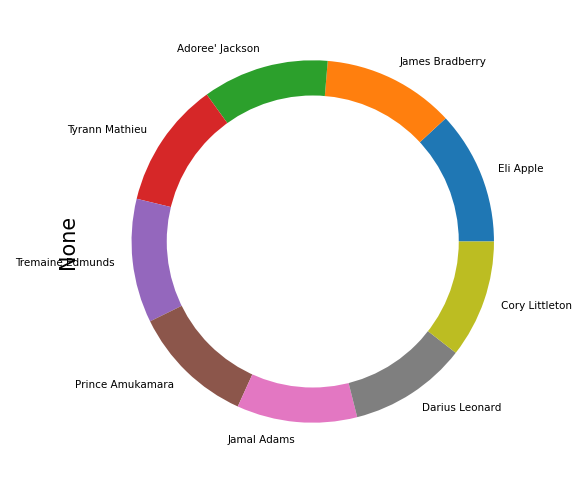

                    19982
Eli Apple             113
James Bradberry       112
Adoree' Jackson       107
Tyrann Mathieu        107
Tremaine Edmunds      105
Prince Amukamara      104
Jamal Adams           102
Darius Leonard        100
Cory Littleton        100
dtype: int64

In [8]:
donut_chart(cover_list)
pd.Series(cover_list).value_counts()[:10]

# How about incompleted passes?
These are the successful covers for these players.

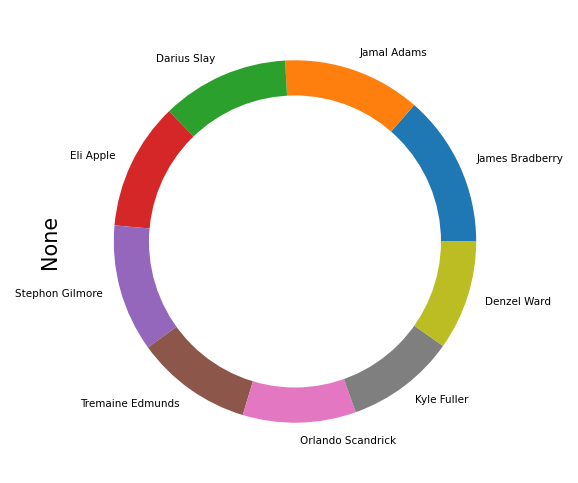

                     7067
James Bradberry        43
Jamal Adams            39
Darius Slay            36
Eli Apple              36
Stephon Gilmore        36
Tremaine Edmunds       33
Orlando Scandrick      32
Kyle Fuller            31
Denzel Ward            31
dtype: int64

In [9]:
completions = plays.query("passResult=='I'")
completions = pd.Series(completions.coverOne.tolist() + completions.coverTwo.tolist())
donut_chart(completions)
pd.Series(completions).value_counts()[:10]

# What about 'IN'?

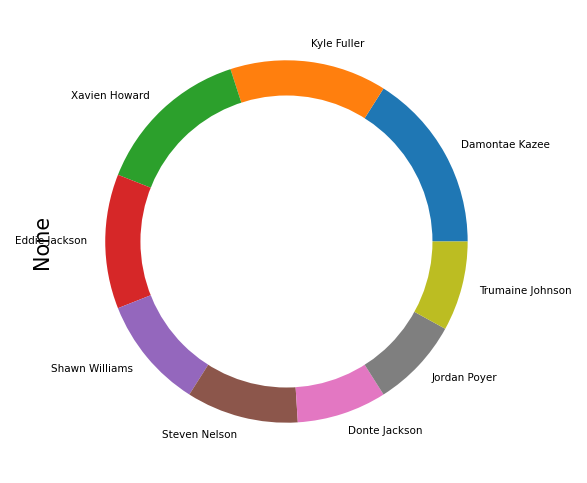

                    444
Damontae Kazee        8
Kyle Fuller           7
Xavien Howard         7
Eddie Jackson         6
Shawn Williams        5
Steven Nelson         5
Donte Jackson         4
Jordan Poyer          4
Trumaine Johnson      4
dtype: int64

In [10]:
completions = plays.query("passResult=='IN'")
completionSeries = pd.Series(completions.coverOne.tolist() + completions.coverTwo.tolist())
donut_chart(completionSeries)
completionSeries.value_counts()[:10]